<a name="top"></a>
# Advent of code 2023

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2023/advent_of_code_2023.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2023/advent_of_code_2023.ipynb)
with Python solutions to the
[2023 Advent of Code puzzles](https://adventofcode.com/2023),
completed in December 2023,
by [Hugues Hoppe](http://hhoppe.com/).

The notebook presents both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is about 6 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)

Here are some visualization results (obtained by setting `SHOW_BIG_MEDIA = True`):

<p>
<a href="#day3">day3</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day03a.png" width="120">&nbsp;
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day03b.png" width="120">&emsp;
<a href="#day6">day6</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day06.gif" width="220">&emsp;
<a href="#day7">day7</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day07.png" width="200">
</p>

<p>
<a href="#day10">day10</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day10a.png" width="100">&nbsp;
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day10b.png" width="100">&emsp;
<a href="#day13">day13</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day13.png" width="280">&emsp;
<a href="#day14">day14</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day14.gif" width="140">
</p>

<p>
<a href="#day16">day16</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day16a.gif" width="200">&emsp;
<a href="#day17">day17</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day17a.gif" width="110">&nbsp;
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day17b.gif" width="110">&emsp;
<a href="#day18">day18</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day18b.png" width="220">
</p>

<p>
<a href="#day20">day20</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day20.png" width="240">&emsp;
<a href="#day21">day21</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day21a.gif" width="240">&emsp;
<a href="#day22">day22</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day22b.gif" width="72">
</p>

<p>
<a href="#day23">day23</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day23d.png" width="180">&nbsp;
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day23b.png" width="180">&emsp;
<a href="#day25">day25</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day25.png" width="320">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null  # For mediapy.

In [2]:
!dpkg -l | grep -q libgraphviz-dev || (apt-get -qq update && apt-get -qq -y install libgraphviz-dev) >/dev/null  # https://stackoverflow.com/a/66380001

In [3]:
!pip install -q advent-of-code-hhoppe hhoppe-tools kaleido matplotlib mediapy more-itertools numba numpy plotly pygraphviz scipy scikit-image sympy

In [4]:
import ast
import collections
from collections.abc import Iterable
import functools
import heapq
import itertools
import math
import pathlib
import re
from typing import Any, Literal

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import matplotlib.animation
import matplotlib.pyplot as plt
import mediapy as media  # https://github.com/google/mediapy/blob/main/mediapy/__init__.py
import more_itertools
import numba
import numpy as np
import plotly.graph_objects as go
import scipy.optimize
import skimage.segmentation
import sympy

try:
  import networkx
except ModuleNotFoundError:
  print('Module networkx is unavailable.')

In [5]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [6]:
if pathlib.Path('results').is_dir():
  media.set_show_save_dir('results')

In [7]:
hh.start_timing_notebook_cells()

In [8]:
YEAR = 2023
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
SHOW_BIG_MEDIA = False
# echo 53616... >~/.config/aocd/token  # session cookie from "adventofcode.com" (valid 1 month).

In [9]:
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
# TAR_URL = ''
advent = advent_of_code_hhoppe.Advent(year=YEAR, tar_url=TAR_URL)

In [10]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [11]:
check_eq = hh.check_eq

In [12]:
def as_latex(array: Any, sym: Literal['pmatrix', 'bmatrix', 'vmatrix'] = 'bmatrix') -> str:
  """Return a LaTeX math string representation of the 2D `array`."""
  array = np.asarray(array)
  assert array.ndim == 2
  s = r' \\ '.join(' & '.join(str(e) for e in row) for row in array)
  return r'\begin{' + sym + '} ' + s + r' \end{' + sym + '}'

In [13]:
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Digit names in strings

- Part 1: Combine the first digit and the last digit (in that order) to form a single two-digit number.  What is the sum?

- Part 2: Some of the digits are actually spelled out with letters.  What is the sum?

---

My approach uses regular expressions.

In [14]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2023/day/1), `puzzle.input` has 1_000 lines:

ckmb52fldxkseven3fkjgcbzmnr7
gckhqpb6twoqnjxqplthree2fourkspnsnzxlz1
2onetwocrgbqm7
frkh2nineqmqxrvdsevenfive
four9two
six7sixqrdfive3twonehsk
xkvsone2
one65
 ...
five2two7hstbbqzrninegbtwo2
eightfblzpmhs4
fbbdeightzzsdffh8jbjzxkclj
3nine6five1


The stored answers are: `{1: '53386', 2: '53312'}`

In [15]:
s1 = """\
1abc2
pqr3stu8vwx
a1b2c3d4e5f
treb7uchet
"""

In [16]:
s2 = """\
two1nine
eightwothree
abcone2threexyz
xtwone3four
4nineeightseven2
zoneight234
7pqrstsixteen
"""

In [17]:
def day1a_part1(s):  # Initial implementation.
  total = 0
  for line in s.splitlines():
    digits = re.findall(r'\d', line)
    total += int(digits[0] + digits[-1])
  return total


def day1a_part2(s):
  names = 'zero one two three four five six seven eight nine'.split()
  values = {name: value for value, name in enumerate(names)} | {str(i): i for i in range(10)}
  pattern = f"({'|'.join(names + list('0123456789'))})"
  total = 0
  for line in s.splitlines():
    name0 = hh.re_groups(pattern, line)[0]
    name1 = hh.re_groups(f'.*{pattern}', line)[0]
    total += values[name0] * 10 + values[name1]
  return total


check_eq(day1a_part1(s1), 142)
puzzle.verify(1, day1a_part1)

check_eq(day1a_part2(s2), 281)
puzzle.verify(2, day1a_part2)

(Part 1: 0.001 s)
(Part 2: 0.002 s)


In [18]:
def day1(s, *, part2=False):  # Concise solution.
  values = {str(i): i for i in range(10)}
  if part2:
    names = 'zero one two three four five six seven eight nine'.split()
    values |= {name: value for value, name in enumerate(names)}

  pattern = '|'.join(values)
  total = 0
  for line in s.splitlines():
    name_first = hh.re_groups(f'({pattern})', line)[0]
    name_last = hh.re_groups(f'.*({pattern})', line)[0]
    total += values[name_first] * 10 + values[name_last]

  return total


check_eq(day1(s1), 142)
puzzle.verify(1, day1)

day1_part2 = functools.partial(day1, part2=True)
check_eq(day1_part2(s2), 281)
puzzle.verify(2, day1_part2)

(Part 1: 0.002 s)
(Part 2: 0.002 s)


<a name="day2"></a>
## Day 2: Bags of colored cubes

- Part 1: Determine which games would have been possible if the bag had been loaded with only 12 red cubes, 13 green cubes, and 14 blue cubes. What is the sum of the IDs of those games?

- Part 2: For each game, find the minimum set of cubes that must have been present. What is the sum of the power of these sets?

---

My approach uses a `dict` dictionary map.

In [19]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2023/day/2), `puzzle.input` has 100 lines:

Game 1: 4 red, 3 blue; 6 blue, 16 green; 9 blue, 13 green, 1 red; 10 green, 4 red, 6 blue
Game 2: 2 green, 3 blue; 11 red; 2 green, 5 red, 1 blue
Game 3: 19 green, 4 blue, 13 red; 1 green, 1 blue, 1 red; 17 red, 18 green
Game 4: 4 green, 8 blue, 20 red; 19 red, 3 green, 14 blue; 15 red, 4 green, 1 bl ... , 10 blue; 3 green, 11 blue, 15 red
Game 5: 1 red, 3 blue, 15 green; 13 green, 2 blue; 6 green; 6 green, 8 blue; 4 green, 9 blue, 1 red
Game 6: 2 green, 10 red; 4 blue, 1 red, 2 green; 2 red, 2 blue, 1 green; 5 red, 3 green, 1 blue
Game 7: 4 green, 2 blue, 10 red; 1 green, 12 red; 5 green, 12 red, 2 blue; 10 re ... e, 5 green; 1 green, 1 blue, 11 red
Game 8: 8 blue, 3 red, 1 green; 9 blue, 14 green, 6 red; 3 red, 15 blue, 16 green; 9 red, 4 green, 6 blue
 ...
Game 97: 8 green, 6 red; 1 blue, 6 red, 10 green; 1 blue, 6 red
Game 98: 2 green, 8 red, 1 blue; 9 green, 2 blue, 7 red; 1 blue, 2 red, 11 green; 8 red, 10 green, 2 blue
Game 99: 3 blue, 2 red; 1 blue, 3 green, 3 red; 1 red, 3 gre

The stored answers are: `{1: '2105', 2: '72422'}`

In [20]:
s1 = """\
Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green
Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue
Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red
Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red
Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green
"""

In [21]:
def day2(s, *, part2=False):
  cubes = dict(red=12, green=13, blue=14)

  def drawn_cubes(game):
    for num_cube in game.split(', '):
      s_num, color = num_cube.split(' ')
      yield int(s_num), color

  def game_possible(game):
    return all(num <= cubes[color] for num, color in drawn_cubes(game))

  total = 0
  for game_id, line in enumerate(s.splitlines(), 1):
    games = line.split(': ')[1].split('; ')
    if part2:
      min_cubes = dict(red=0, green=0, blue=0)
      for game in games:
        for num, color in drawn_cubes(game):
          min_cubes[color] = max(min_cubes[color], num)
      total += math.prod(min_cubes.values())
    elif all(game_possible(game) for game in games):
      total += game_id

  return total


check_eq(day2(s1), 8)
puzzle.verify(1, day2)

day2_part2 = functools.partial(day2, part2=True)
check_eq(day2_part2(s1), 2286)
puzzle.verify(2, day2_part2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day3"></a>
## Day 3: Digit components in a grid

- Part 1: Any number adjacent to a symbol, even diagonally, is a "part number".  What is the sum of all of the part numbers in the engine schematic?

- Part 2: A gear is any `*` symbol that is adjacent to exactly two part numbers.  What is the sum of all of the gear ratios in your engine schematic?

---

The solution uses a `numpy` 2D array and lots of generators.
In particular, it generates "spans" which are horizontal 1D slices within the 2D array.

In [22]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2023/day/3), `puzzle.input` has 140 lines:

....411...............838......721.....44....................................... ... ...................................
...&......519..................*..........#.97.........994..............404..... ... 40...882.......673.505.............
.....*......*...892.........971...%....131....*..........*.......515...$.......1 ... ....*.............*............594.
..856.495....13...-...............602..........36...$.985....341*.........88.... ... .122..................806..508.....
......................667.325*734.................718...............284..*....28 ... .........643....817....*...........
....*480..825..........*....................784.......&.............*...859..... ... .....................137...........
............*..903*986.681....403.....451...*.....424..24.855....844............ ... -.........542%..564......@.212*....
......735...70.............=.....*895.......575.....*......*.............490.... ... 0....519...........*857.88.....761.
 ...
.567........945....*.......

The stored answers are: `{1: '527446', 2: '73201705'}`

In [23]:
s1 = """\
467..114..
...*......
..35..633.
......#...
617*......
.....+.58.
..592.....
......755.
...$.*....
.664.598..
"""

In [24]:
def day3a_part1(s):  # Initial custom solution for Part 1.
  grid = np.array([list(line) for line in s.splitlines()])
  dyxs = tuple(set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)})

  def neighbors(yx):
    for dyx in dyxs:
      y, x = yx[0] + dyx[0], yx[1] + dyx[1]
      if 0 <= y < grid.shape[0] and 0 <= x < grid.shape[1]:
        yield y, x

  def remove_number(y, x):
    while x > 0 and grid[y, x - 1].isdigit():  # Move to first digit.
      x -= 1
    value = 0
    while x < grid.shape[1] and grid[y, x].isdigit():
      value = value * 10 + int(grid[y, x])
      grid[y, x] = '.'
      x += 1
    return value

  total = 0
  for yx, ch in np.ndenumerate(grid):
    if not (ch.isdigit() or ch == '.'):  # Symbol
      for yx2 in neighbors(yx):
        if grid[yx2].isdigit():
          value = remove_number(*yx2)
          total += value
  return total


check_eq(day3a_part1(s1), 4361)
puzzle.verify(1, day3a_part1)

(Part 1: 0.012 s)


In [25]:
def day3b(s, *, part2=False, visualize=False):  # First general solution, before compactification.
  grid = np.array([list(line) for line in s.splitlines()])

  def neighbors(yx):
    dyxs = tuple(set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)})
    for dyx in dyxs:
      y, x = yx[0] + dyx[0], yx[1] + dyx[1]
      if 0 <= y < grid.shape[0] and 0 <= x < grid.shape[1]:
        yield y, x

  def number_span(y, x):
    while x > 0 and grid[y, x - 1].isdigit():  # Move to first digit.
      x -= 1
    start_x = x
    while x < grid.shape[1] and grid[y, x].isdigit():
      x += 1
    # A slice object becomes hashable in Python 3.12: https://stackoverflow.com/a/76562346/1190077
    return y, start_x, x

  def adjacent_number_spans(yx):
    return {number_span(*yx2) for yx2 in neighbors(yx) if grid[yx2].isdigit()}

  def get_value(y, x_start, x_stop):
    return int(''.join(grid[y, x_start:x_stop]))

  if visualize:
    is_symbol = ~np.char.isdigit(grid) & ~(grid == '.')
    image = np.full(grid.shape + (3,), 245, np.uint8)
    image[np.char.isdigit(grid)] = 155
    image[is_symbol] = 0, 0, 255
    if part2:
      for yx, ch in np.ndenumerate(grid):
        if ch == '*' and len(spans := adjacent_number_spans(yx)) == 2:
          image[yx] = 230, 0, 0
          for y, x_start, x_stop in spans:
            image[y, x_start:x_stop] = 255, 180, 0
    else:
      yxs = (yx for yx, ch in np.ndenumerate(grid) if is_symbol[yx])
      spans = set.union(*(adjacent_number_spans(yx) for yx in yxs))
      for y, x_start, x_stop in spans:
        image[y, x_start:x_stop] = 0, 220, 0
    image = image.repeat(3, axis=0).repeat(3, axis=1)
    media.show_image(image, title=f'day03{"ab"[part2]}')

  if part2:
    total = 0
    for yx, ch in np.ndenumerate(grid):
      if ch == '*':
        spans = adjacent_number_spans(yx)
        if len(spans) == 2:
          total += math.prod(get_value(*span) for span in spans)
    return total

  spans = set()
  for yx, ch in np.ndenumerate(grid):
    if not (ch.isdigit() or ch == '.'):  # Symbol
      spans |= adjacent_number_spans(yx)
  return sum(get_value(*span) for span in spans)


check_eq(day3b(s1), 4361)
puzzle.verify(1, day3b)

day3b_part2 = functools.partial(day3b, part2=True)
check_eq(day3b_part2(s1), 467835)
puzzle.verify(2, day3b_part2)

(Part 1: 0.013 s)
(Part 2: 0.011 s)


day03a

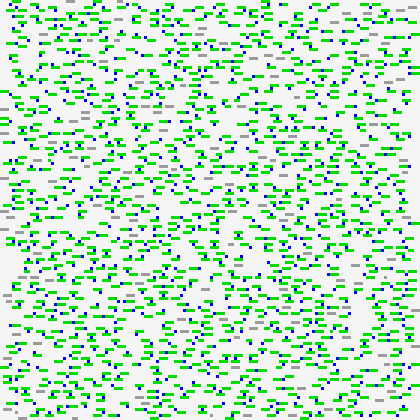

day03b

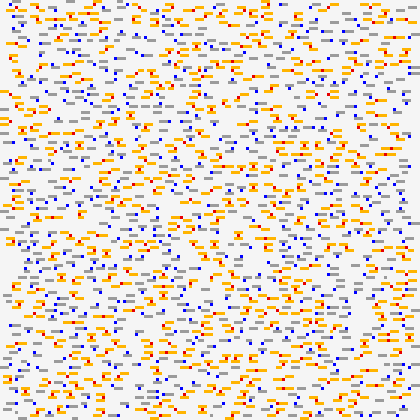

In [26]:
_ = day3b(puzzle.input, visualize=True)
_ = day3b(puzzle.input, visualize=True, part2=True)

In [27]:
def day3(s, *, part2=False):
  grid = np.pad([list(line) for line in s.splitlines()], 1, constant_values='.')

  def neighbors(y, x):
    for dy, dx in set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}:
      yield y + dy, x + dx

  def number_span(y, x):
    while grid[y, x - 1].isdigit():  # Move to first digit.
      x -= 1
    x_start = x
    while grid[y, x].isdigit():  # Move past last digit.
      x += 1
    return y, x_start, x

  def adjacent_number_spans(yx):
    return {number_span(*yx2) for yx2 in neighbors(*yx) if grid[yx2].isdigit()}

  def get_value(y, x_start, x_stop):
    return int(''.join(grid[y, x_start:x_stop]))

  if part2:
    yxs2 = np.argwhere(grid == '*')
    gears = (spans for yx in yxs2 if len(spans := adjacent_number_spans(yx)) == 2)
    return sum(math.prod(get_value(*span) for span in gear) for gear in gears)

  yxs1 = (yx for yx, ch in np.ndenumerate(grid) if ch not in '.0123456789')
  spans = set.union(*(adjacent_number_spans(yx) for yx in yxs1))
  return sum(get_value(*span) for span in spans)


check_eq(day3(s1), 4361)
puzzle.verify(1, day3)

day3_part2 = functools.partial(day3, part2=True)
check_eq(day3_part2(s1), 467835)
puzzle.verify(2, day3_part2)

(Part 1: 0.012 s)
(Part 2: 0.006 s)


<a name="day4"></a>
## Day 4: Matching numbers on cards

- Part 1: The first match makes the card worth one point and each match after the first doubles the point value of that card.  How many points are they worth in total?

- Part 2: You win copies of the scratchcards below the winning card equal to the number of matches.  How many total scratchcards do you end up with?

---

The approach is to use `set` intersection to count matches, and to maintain the number of copies of scratchcards as a `dict` dictionary.

In [28]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2023/day/4), `puzzle.input` has 187 lines:

Card   1: 20 72 30 38 18 65  6 55 70 27 | 12 28 47 50 60 17 14 25 41 95 66 88 61 52 76  5 23 77 31 32 99 89 53 54 96
Card   2: 15 98 12  3 20 60 58 54 34 18 | 98 23 12 19 61 38 11 43 58 97 63 10 49 67 44 52 88  4 22  1 42 65 20 13 25
Card   3: 47 97  2 80 89 56 66 85 62 46 | 78 97 47 14 15 85 42 66 24 28 54 46 89 62 80 56 22  5 57 52 69  2  3 95 19
Card   4: 60 59 88 14 53 46 96 29 99 37 | 52 46 92 26 72 74 99 38  7 65 43 63 39 36 44  9 56 42 79 50 89 48 85 28 27
Card   5: 44 46 42  9 65 98 97 67 72 22 | 80 14 29 39 98 64  9 46 52 24 69 22 51 65 66 20 72 21 55 12 97 42 44 41 67
Card   6: 53 92  3 77 46 68 11 23 81 88 | 42  3 92  4 23 43 62 81 51  1 29 88 35 68 84 95 59 77 11 36 53 76 49 46 34
Card   7: 66 24 96 25 11 60 15 18 67 87 | 25 66 96 11 87 31 57 56 15 18 27  1 98 40 22 60 86 80 10 97 67 24 64 59 81
Card   8: 76 38 87 23 60 16  7 18 70 14 | 50 80 91 16 89 76 63 32 26  1 38 77 35 28 68 12 97  7 43 34 37 39 98  8 70
 ...
Card 184: 10 41 56 32 84 29 85 26 34 27 |  6  4  9 38 25 26

The stored answers are: `{1: '22674', 2: '5747443'}`

In [29]:
s1 = """\
Card 1: 41 48 83 86 17 | 83 86  6 31 17  9 48 53
Card 2: 13 32 20 16 61 | 61 30 68 82 17 32 24 19
Card 3:  1 21 53 59 44 | 69 82 63 72 16 21 14  1
Card 4: 41 92 73 84 69 | 59 84 76 51 58  5 54 83
Card 5: 87 83 26 28 32 | 88 30 70 12 93 22 82 36
Card 6: 31 18 13 56 72 | 74 77 10 23 35 67 36 11
"""

In [30]:
def day4(s, *, part2=False):
  copies = collections.Counter[int]()
  total = 0

  for card_id, line in enumerate(s.splitlines()):
    winning, have = map(str.split, line.split(':')[1].split(' | '))
    num_matches = len(set(winning) & set(have))
    if part2:
      value = 1 + copies[card_id]
      for i in range(num_matches):
        copies[card_id + 1 + i] += value
      total += value
    elif num_matches:
      total += 2 ** (num_matches - 1)

  return total


check_eq(day4(s1), 13)
puzzle.verify(1, day4)

day4_part2 = functools.partial(day4, part2=True)
check_eq(day4_part2(s1), 30)
puzzle.verify(2, day4_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day5"></a>
## Day 5: Successive range remaps

- Part 1: Each line within a map contains three numbers: the destination range start, the source range start, and the range length.  What is the lowest location number that corresponds to any of the initial seed numbers?

- Part 2: The values on the initial seeds: line come in pairs. Within each pair, the first value is the start of the range and the second value is the length of the range.  What is the lowest location number that corresponds to any of the initial seed numbers?

---

For the challenging Part 2, my first approach is to use a recursive generator, which uses both `yield` and `yield from`.
My second (and faster) approach is non-recursive, with two loops and and two update lists.

In [31]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2023/day/5), `puzzle.input` has 190 lines:

seeds: 1636419363 608824189 3409451394 227471750 12950548 91466703 1003260108 22 ... 4590 426344831 1433781343 153722422

seed-to-soil map:
2067746708 2321931404 124423068
2774831547 3357841131 95865403
3776553292 3323317283 34523848
4167907733 3453706534 116376261
1190847573 767701596 554806188
 ...
1060795937 1463902630 11997149
830057911 3067209644 147678249
1254184202 1194301285 19606964
1486504318 1775591971 115009557


The stored answers are: `{1: '309796150', 2: '50716416'}`

In [32]:
s1 = """\
seeds: 79 14 55 13

seed-to-soil map:
50 98 2
52 50 48

soil-to-fertilizer map:
0 15 37
37 52 2
39 0 15

fertilizer-to-water map:
49 53 8
0 11 42
42 0 7
57 7 4

water-to-light map:
88 18 7
18 25 70

light-to-temperature map:
45 77 23
81 45 19
68 64 13

temperature-to-humidity map:
0 69 1
1 0 69

humidity-to-location map:
60 56 37
56 93 4
"""

In [33]:
def day5a_part1(s):  # Initial implementation of just Part 1.
  sections = s.strip('\n').split('\n\n')
  (line,) = sections[0].splitlines()
  values = list(map(int, line.split(': ')[1].split()))

  for section in sections[1:]:
    new_values = []
    for value in values:
      for line in section.splitlines()[1:]:
        dst, src, num = map(int, line.split())
        if src <= value < src + num:
          value = dst + (value - src)
          break
      new_values.append(value)
    values = new_values

  return min(values)


check_eq(day5a_part1(s1), 35)
puzzle.verify(1, day5a_part1)

(Part 1: 0.001 s)


In [34]:
def day5b(s, *, part2=False):  # First (non-simplified) recursive generator.
  sections = s.split('\n\n')
  (line,) = sections[0].splitlines()
  values = map(int, line.split(': ')[1].split())
  if part2:
    intervals: Any = list(more_itertools.batched(values, 2))
  else:
    intervals = [(start, 1) for start in values]

  def remap(start, n, lines):
    if not lines:
      yield start, n
    else:
      dst, src, num = map(int, lines[0].split())
      if src <= start < src + num:
        yield dst + (start - src), min(n, src + num - start)
        if src + num < start + n:
          yield from remap(src + num, start + n - (src + num), lines[1:])
      elif start < src < start + n:
        yield from remap(start, src - start, lines[1:])
        yield dst, min(num, n - (src - start))
        if src + num < start + n:
          yield from remap(src + num, start + n - (src + num), lines[1:])
      else:
        yield from remap(start, n, lines[1:])

  for section in sections[1:]:
    lines = section.splitlines()[1:]
    intervals = [interval for start, n in intervals for interval in remap(start, n, lines)]

  return min(start for start, _ in intervals)


check_eq(day5b(s1), 35)
puzzle.verify(1, day5b)

day5b_part2 = functools.partial(day5b, part2=True)
check_eq(day5b_part2(s1), 46)
puzzle.verify(2, day5b_part2)

(Part 1: 0.001 s)
(Part 2: 0.003 s)


In [35]:
def day5c(s, *, part2=False):  # Simplified recursive generator.
  sections = s.split('\n\n')
  (line,) = sections[0].splitlines()
  values = map(int, line.split(': ')[1].split())
  if part2:
    intervals = [(start, start + n) for start, n in more_itertools.batched(values, 2)]  # type: ignore[misc]
  else:
    intervals = [(start, start + 1) for start in values]

  def remap(start, stop, lines):
    if not lines:
      yield start, stop
    else:
      dst, src, num = map(int, lines[0].split())
      i0, i1 = max(src, start), min(src + num, stop)
      if i0 < i1:
        yield dst + (i0 - src), dst + (i1 - src)
      if i0 > start:
        yield from remap(start, min(i0, stop), lines[1:])
      if i1 < stop:
        yield from remap(max(i1, start), stop, lines[1:])

  for section in sections[1:]:
    lines = section.splitlines()[1:]
    chain = itertools.chain.from_iterable
    intervals = list(chain(remap(*interval, lines) for interval in intervals))

  return min(start for start, _ in intervals)


check_eq(day5c(s1), 35)
puzzle.verify(1, day5c)

day5c_part2 = functools.partial(day5c, part2=True)
check_eq(day5c_part2(s1), 46)
puzzle.verify(2, day5c_part2)

(Part 1: 0.001 s)
(Part 2: 0.004 s)


In [36]:
def day5(s, *, part2=False):  # Non-recursive implementation.
  sections = s.split('\n\n')
  (line,) = sections[0].splitlines()
  values = map(int, line.split(': ')[1].split())
  if part2:
    intervals: Any = [(start, start + n) for start, n in more_itertools.batched(values, 2)]  # type: ignore[misc]
  else:
    intervals = [(start, start + 1) for start in values]

  for section in sections[1:]:
    output_intervals = []
    for line in section.splitlines()[1:]:
      dst, src, num = map(int, line.split())
      new_intervals = []
      for start, stop in intervals:
        i0, i1 = max(src, start), min(src + num, stop)
        if i0 < i1:
          output_intervals.append((dst + (i0 - src), dst + (i1 - src)))
        if i0 > start:
          new_intervals.append((start, min(i0, stop)))
        if i1 < stop:
          new_intervals.append((max(i1, start), stop))
      intervals = new_intervals
    intervals.extend(output_intervals)

  return min(start for start, _ in intervals)


check_eq(day5(s1), 35)
puzzle.verify(1, day5)

day5_part2 = functools.partial(day5, part2=True)
check_eq(day5_part2(s1), 46)
puzzle.verify(2, day5_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day6"></a>
## Day 6: Charge-up before race

- Part 1: Your toy boat has a starting speed of zero millimeters per millisecond. For each whole millisecond you spend at the beginning of the race holding down the button, the boat's speed increases by one millimeter per millisecond.  Determine the number of ways you could beat the record in each race. What do you get if you multiply these numbers together?

- Part 2: There's really only one race - ignore the spaces between the numbers on each line.  How many ways can you beat the record in this one much longer race?

---

The distance traveled is a quadratic function of the start time.
The fastest approach is to determine the interval of successful start times by solving for the roots of a quadratic equation.

In [37]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2023/day/6), `puzzle.input` has 2 lines:

Time:        53     83     72     88
Distance:   333   1635   1289   1532


The stored answers are: `{1: '140220', 2: '39570185'}`

In [38]:
s1 = """\
Time:      7  15   30
Distance:  9  40  200
"""

In [39]:
def day6a(s, *, part2=False):  # Brute-force.
  if part2:
    s = s.replace(' ', '')
  s_times, s_distances = s.splitlines()
  times = list(map(int, s_times.split(':')[1].split()))
  distances = list(map(int, s_distances.split(':')[1].split()))
  product = 1
  for time, distance in zip(times, distances):
    num_wins = 0
    for t in range(time):
      d = (time - t) * t
      num_wins += d > distance
    product *= num_wins
  return product


check_eq(day6a(s1), 288)
puzzle.verify(1, day6a)

day6a_part2 = functools.partial(day6a, part2=True)
check_eq(day6a_part2(s1), 71503)
# puzzle.verify(2, day6a_part2)  # Slow; ~3 s.

(Part 1: 0.000 s)


In [40]:
def day6b(s, *, part2=False):  # Brute-force, compactified.
  if part2:
    s = s.replace(' ', '')
  ts, ds = (list(map(int, line.split(':')[1].split())) for line in s.splitlines())

  def num_wins(t, d):
    return sum((t - x) * x > d for x in range(t))

  return math.prod(num_wins(t, d) for t, d in zip(ts, ds))


check_eq(day6b(s1), 288)
puzzle.verify(1, day6b)

day6b_part2 = functools.partial(day6b, part2=True)
check_eq(day6b_part2(s1), 71503)
# puzzle.verify(2, day6b_part2)  # Slow; ~3 s.

(Part 1: 0.000 s)


In [41]:
def day6_part1_visualize(s, fps=20, delay_start=20, delay_end=40):
  ts, ds = (list(map(int, line.split(':')[1].split())) for line in s.splitlines())
  t1, d1 = ts[0], ds[0]

  fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
  ax.set(title=f'Successful start times for Time={t1} Distance={d1}')
  ax.set(xlim=(0, t1 + 1), ylim=(-20, 800), xlabel='Start time', ylabel='Distance traveled')
  ax.plot([0, t1 + 1], [d1, d1], '-', color='green', linewidth=0.8)
  ax.grid(True, lw=0.3)
  fig.tight_layout()
  artists = {}
  for start in range(t1 + 1):
    artists[start] = (
        ax.plot([], [], '-', color='grey', linewidth=2)[0],
        ax.plot([], [], 'o', markersize=5)[0],
    )
  plt.close()

  def animate(t):
    t = min(max(t - delay_start, 0), t1)
    for start, artist in artists.items():
      d = max(0, t - start) * start
      artist[0].set_data([start, start], [0, d])
      artist[1].set_data([start], [d])
      artist[1].set_color('blue' if d <= d1 else 'green')
    return itertools.chain.from_iterable(artists.values())

  animator = matplotlib.animation.FuncAnimation(
      fig, animate, frames=t1 + delay_start + delay_end, interval=1000 // fps, blit=True
  )
  if 0:
    with plt.rc_context():
      plt.rcParams['animation.html'] = 'html5'  # Enable HTML video; default is 'none'.
      hh.display(animator)

  if (path := pathlib.Path('results') / 'day06.gif').parent.is_dir():
    animator.save(path, writer='ffmpeg', fps=fps, dpi=100, codec='gif')
    with media.VideoReader(path) as reader:
      h, w = reader.shape
    html = media.html_from_compressed_image(path.read_bytes(), w, h, fmt='gif', pixelated=False)
    hh.display_html(html)


if SHOW_BIG_MEDIA:
  day6_part1_visualize(puzzle.input)

Cached result:<br/>
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day06.gif"/><br/>

In [42]:
def day6(s, *, part2=False):  # Solving quadratic equation.
  if part2:
    s = s.replace(' ', '')
  ts, ds = (map(int, line.split(':')[1].split()) for line in s.splitlines())

  def num_wins(t, d):
    # Quadratic equation -t**2 * x**2 + t * x - d = 0 has roots x = u \pm v with:
    u, v = t / 2, (t**2 - 4 * d) ** 0.5 / 2
    # return math.ceil(u + v - 1) - math.floor(u - v + 1) + 1
    return math.ceil(u + v) - math.floor(u - v) - 1

  return math.prod(num_wins(t, d) for t, d in zip(ts, ds))


check_eq(day6(s1), 288)
puzzle.verify(1, day6)

day6_part2 = functools.partial(day6, part2=True)
check_eq(day6_part2(s1), 71503)
puzzle.verify(2, day6_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day7"></a>
## Day 7: Poker-variant hand ranking

- Part 1: Hands are primarily ordered based on type (five of a kind, ..., high card).
  If two hands have the same type, they are further ordered based on sequence of labels (2..9, T=10, J=11, Q=12, K=13, A=14).
  Each hand wins an amount equal to its bid multiplied by its rank, where the weakest hand gets rank 1.
  What are the total winnings?


- Part 2: The `J` cards are jokers that act as wildcards in determining hand type and act as value 1 in label ordering.

---



In [43]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2023/day/7), `puzzle.input` has 1_000 lines:

4K8J9 314
982KT 991
88J55 371
77744 552
6268J 995
9A7JJ 495
2J28T 373
88666 601
 ...
46444 469
46J24 322
T42Q8 864
88989 929


The stored answers are: `{1: '253866470', 2: '254494947'}`

In [44]:
s1 = """\
32T3K 765
T55J5 684
KK677 28
KTJJT 220
QQQJA 483
"""

In [45]:
def day7a(s, *, part2=False):  # Using a rank dictionary and Counter.most_common().
  hand_bids = [line.split() for line in s.splitlines()]
  rank = {str(i): i for i in range(2, 10)} | dict(T=10, J=(11, 1)[part2], Q=12, K=13, A=14)

  def hand_rank(hand):
    non_jokers = [card for card in hand if not (card == 'J' and part2)]
    num_jokers = len(hand) - len(non_jokers)
    c = collections.Counter(non_jokers).most_common() or [('A', 0)]
    return c[0][1] + num_jokers, (c[1][1] if c[1:] else 0), [rank[card] for card in hand]

  hand_bids.sort(key=lambda t: hand_rank(t[0]))
  return sum(int(bid) * i for i, (_, bid) in enumerate(hand_bids, 1))


check_eq(day7a(s1), 6440)
puzzle.verify(1, day7a)

day7a_part2 = functools.partial(day7a, part2=True)
check_eq(day7a_part2(s1), 5905)
puzzle.verify(2, day7a_part2)

(Part 1: 0.003 s)
(Part 2: 0.003 s)


In [46]:
def day7(s, *, part2=False):  # Using a rank string and a sorted list of counts from Counter.
  # With ideas from https://github.com/lkesteloot/advent-of-code/blob/master/2023/7.py
  rank = ['23456789TJQKA', 'J23456789TQKA'][part2]

  def order(hand):
    non_jokers = [card for card in hand if not (card == 'J' and part2)]
    counts = sorted(collections.Counter(non_jokers).values())[::-1] or [0]
    counts[0] += len(hand) - len(non_jokers)
    return counts, [rank.index(card) for card in hand]

  hand_bids = sorted((line.split() for line in s.splitlines()), key=lambda t: order(t[0]))
  return sum(int(bid) * i for i, (_, bid) in enumerate(hand_bids, 1))


check_eq(day7(s1), 6440)
puzzle.verify(1, day7)

day7_part2 = functools.partial(day7, part2=True)
check_eq(day7_part2(s1), 5905)
puzzle.verify(2, day7_part2)

(Part 1: 0.003 s)
(Part 2: 0.003 s)


<a name="day8"></a>
## Day 8: Parallel walks over graph

- Part 1: Starting at AAA, follow the left/right instructions. How many steps are required to reach ZZZ?

- Part 2: Start at every node that ends with A and follow all of the paths at the same time until they all simultaneously end up at nodes that end with Z.  How many steps does it take before you're only on nodes that end with Z?

---

For Part 2, the approach is to run the simulation for some time and detect state cycles for each of the advancing "ghosts".  In general, each cycle has a different period, and within that period, there can be multiple phases at which a solution is possible.
The general implementation below determines these periods and phases.

We observe that there is only one phase for each cycle.
Thus, we obtain the solution by applying the Chinese remainder theorem.
However, that theorem requires that the periods (moduli) be co-prime, which is not the case here.
We implement a generalized version that supports non-co-prime moduli.

We further observe that the phase equals zero for all cycles.
(A visualization of the graph structure encoded in the puzzle input explains this special phase property.)
Because all phases are zero, a simpler solution is to simply compute the least common multiple (lcm) of the cycle periods.

In [47]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2023/day/8), `puzzle.input` has 720 lines:

LRLLLRRLRRLRRLRRLLRRLRRLLRRRLLRRLRRLRRLRRLRLRLLLLLRRLRRLLRLRRRLLRRLRLLLLLLLRRLRL ... RRRLRRRLRRLRLRRRLRRRLRLLLRRLRLLRRRR

RLP = (BMK, PCM)
JTJ = (TVN, CJQ)
PFR = (MMX, BQC)
JGM = (NDJ, PCV)
LVD = (TCK, PVR)
SVS = (CDL, RNX)
 ...
NFH = (SGJ, MJQ)
NMK = (QXF, DGS)
XLM = (CTR, HNK)
NQN = (SJT, BFL)


The stored answers are: `{1: '17141', 2: '10818234074807'}`

In [48]:
# The sequence of moves 'RRRR' occurs only once within the instructions --- at its end.
hh.display_html(f"{len(puzzle.input.splitlines()[0]) = }  {puzzle.input.index('RRRR') = }")

In [49]:
s1 = """\
RL

AAA = (BBB, CCC)
BBB = (DDD, EEE)
CCC = (ZZZ, GGG)
DDD = (DDD, DDD)
EEE = (EEE, EEE)
GGG = (GGG, GGG)
ZZZ = (ZZZ, ZZZ)
"""

In [50]:
s2 = """\
LLR

AAA = (BBB, BBB)
BBB = (AAA, ZZZ)
ZZZ = (ZZZ, ZZZ)
"""

In [51]:
s3 = """\
LR

11A = (11B, XXX)
11B = (XXX, 11Z)
11Z = (11B, XXX)
22A = (22B, XXX)
22B = (22C, 22C)
22C = (22Z, 22Z)
22Z = (22B, 22B)
XXX = (XXX, XXX)
"""

In [52]:
def _extended_gcd(a: int, b: int) -> tuple[int, int, int]:
  """Finds the greatest common divisor using the extended Euclidean algorithm."""
  # Returns: (gcd(a, b), x, y) with the property that a * x + b * y = gcd(a, b).
  prev_x, x = 1, 0
  prev_y, y = 0, 1
  while b:
    q = a // b
    x, prev_x = prev_x - q * x, x
    y, prev_y = prev_y - q * y, y
    a, b = b, a % b
  return a, prev_x, prev_y


assert _extended_gcd(29, 71) == (1, -22, 9) and (29 * -22) % 71 == 1

In [53]:
def _solve_modulo_congruences(moduli: Iterable[int], remainders: Iterable[int]) -> int:
  """Returns `x` satisfying `x % moduli[i] == remainders[i]`; handles non-coprime moduli."""

  def merge(mr1, mr2):
    (m, a), (n, b) = mr1, mr2
    gcd, u, v = _extended_gcd(m, n)
    if 0:  # Simpler algorithm that assumes the moduli are coprime.
      return m * n, (a * v * n + b * u * m) % (m * n)
    # General algorithm; see https://math.stackexchange.com/a/1644698.
    lamb = (a - b) // gcd
    sigma = a - m * u * lamb
    assert sigma == b + n * v * lamb
    lcm = math.lcm(m, n)
    return lcm, sigma % lcm

  return functools.reduce(merge, zip(moduli, remainders))[1]


assert _solve_modulo_congruences([5, 7, 11], [3, 6, 6]) == 83
assert _solve_modulo_congruences([2, 3, 4, 5, 6], [1, 1, 1, 1, 1]) == 1

In [54]:
def day8a(s, *, part2=False):  # General algorithm that finds periods and phases.
  lines = s.splitlines()
  moves = lines[0]
  routes = {}
  for line in lines[2:]:
    src, dsts = line.split(' = ')
    routes[src] = dsts[1:-1].split(', ')

  def advance(node, move):
    return routes[node][{'L': 0, 'R': 1}[move]]

  if not part2:
    node = 'AAA'
    for index, move in enumerate(itertools.cycle(moves)):
      if node == 'ZZZ':
        return index
      node = advance(node, move)

  # Run an initial simulation long enough that all nodes should be cycling.
  nodes = {node for node in routes if node.endswith('A')}
  num = 1_000
  for index, move in enumerate(itertools.islice(itertools.cycle(moves), num)):
    if all(node.endswith('Z') for node in nodes):
      return index
    nodes = {advance(node, move) for node in nodes}

  # Identify the periods and phases of the cycles.
  moduli, remainders = [], []
  for node in nodes:
    last_seen: dict[str, int] = {}
    for index, move in enumerate(itertools.islice(itertools.cycle(moves), num, None)):
      if node.endswith('Z'):
        if node in last_seen:
          moduli.append(index - last_seen[node])
          break
        last_seen[node] = index
      node = advance(node, move)
    # Fortunately, the problem is special in that each cycle contains a single solution.
    assert len(last_seen) == 1
    remainders.append(last_seen[node])

  if 1:
    # The length of each graph loop (e.g., 43, 47, 59, 61, 67, 79) is co-prime with the number of
    # instructions (e.g, 281) so each observed cycle period is the pairwise product.
    hh.display_html(f'{len(moves) = }<br/>{moduli = }<br/>{remainders = }')
    hh.display_html(f'moduli factors: {[hh.prime_factors(v) for v in moduli]}')

  index = num + _solve_modulo_congruences(moduli, remainders)
  if 1:  # A particular property of this particular input:
    # The remainders happen to align such that the solution lies exactly at math.lcm(*moduli)!
    assert all(remainder + num == modulo for modulo, remainder in zip(moduli, remainders))
    assert index == math.lcm(*moduli)
  return index


check_eq(day8a(s1), 2)
check_eq(day8a(s2), 6)
puzzle.verify(1, day8a)

day8a_part2 = functools.partial(day8a, part2=True)
check_eq(day8a_part2(s3), 6)
puzzle.verify(2, day8a_part2)

(Part 1: 0.003 s)


(Part 2: 0.039 s)


day07

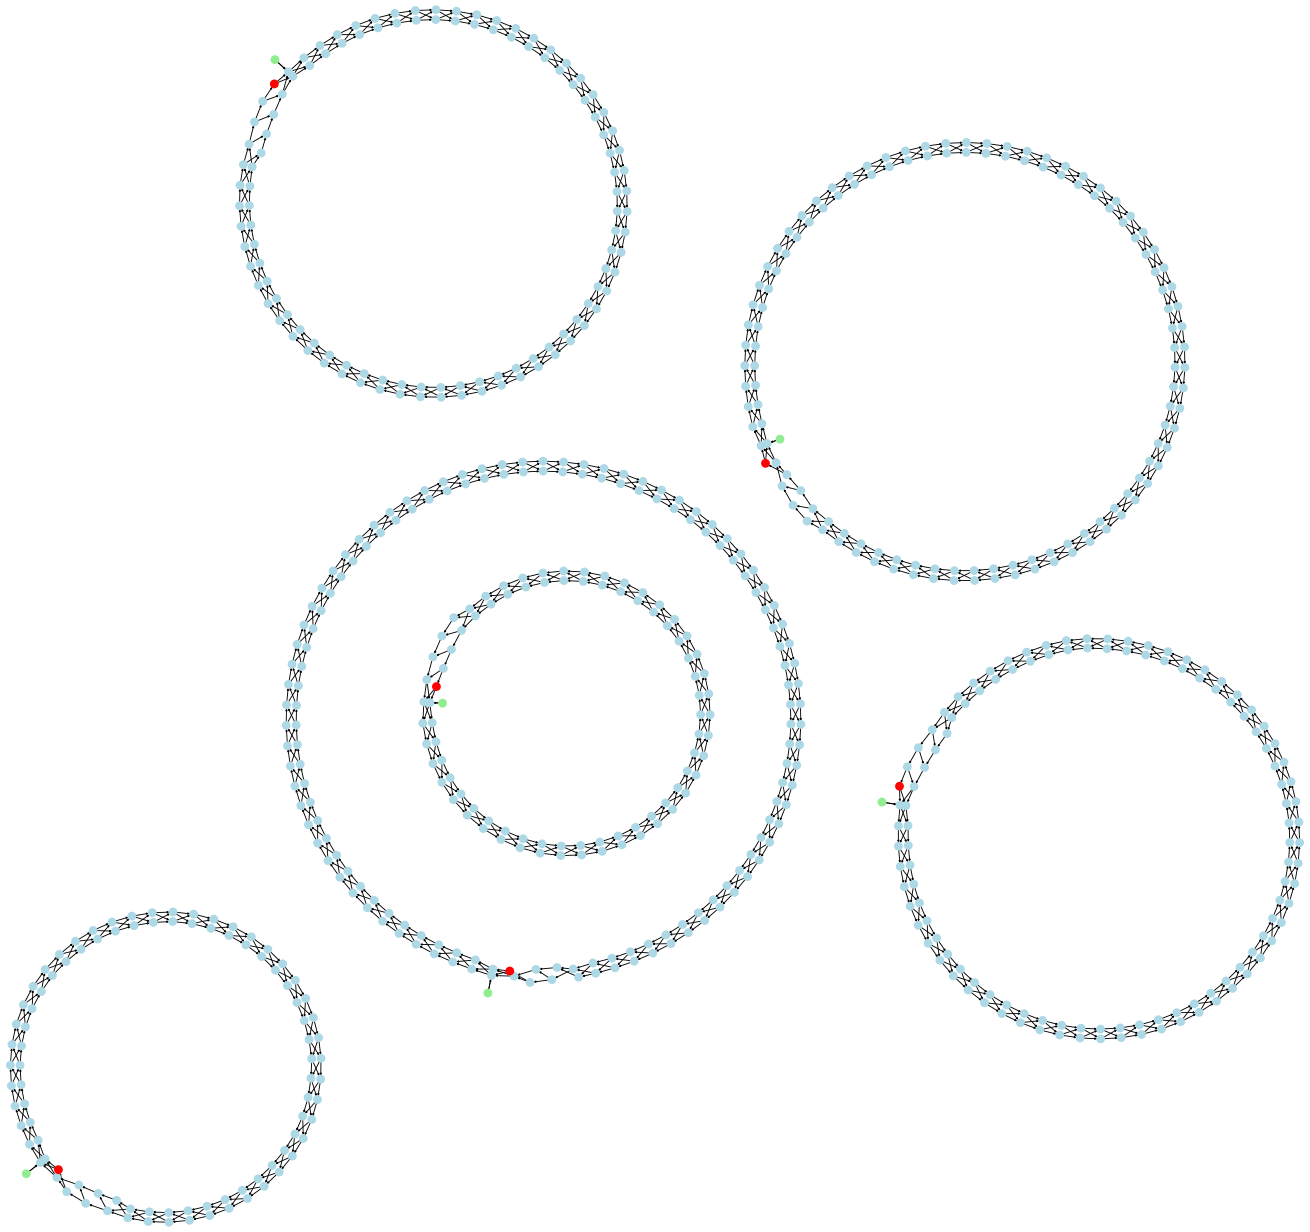

In [55]:
def day8_visualize(s):
  routes = {line[:3]: (line[7:10], line[12:15]) for line in s.splitlines()[2:]}
  graph = networkx.DiGraph()
  for node, dsts in routes.items():
    color = 'lightgreen' if node.endswith('A') else 'red' if node.endswith('Z') else 'lightblue'
    graph.add_node(node, node_color=color)
    for dst in dsts:
      graph.add_edge(node, dst)

  pos = hh.graph_layout(graph, prog='neato')  # prog='dot' is impossibly slow.
  fig, ax = plt.subplots(figsize=(12, 12), dpi=130)
  ax.axes.set_aspect('equal')
  node_color = [attr for _, attr in graph.nodes(data='node_color')]
  networkx.draw(graph, pos, node_size=15, node_color=node_color, width=0.5, arrowsize=2)
  fig.tight_layout(pad=0)
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  media.show_image(image, border=True, title='day07')
  plt.close(fig)


if 'networkx' in globals():
  media.set_max_output_height(3000)
  day8_visualize(puzzle.input)

In [56]:
def day8(s, *, part2=False):  # Special-case algorithm that assumes that all phases are zero.
  lines = s.splitlines()
  routes = {line[:3]: (line[7:10], line[12:15]) for line in lines[2:]}

  def length(node, end):
    for index, ch in enumerate(itertools.cycle(lines[0])):
      if node.endswith(end):
        return index
      node = routes[node][ch == 'R']

  if part2:
    return math.lcm(*(length(node, 'Z') for node in routes if node.endswith('A')))
  return length('AAA', 'ZZZ')


check_eq(day8(s1), 2)
check_eq(day8(s2), 6)
puzzle.verify(1, day8)

day8_part2 = functools.partial(day8, part2=True)
check_eq(day8_part2(s3), 6)
puzzle.verify(2, day8_part2)

(Part 1: 0.002 s)
(Part 2: 0.009 s)


<a name="day9"></a>
## Day 9: Nth difference extrapolation

- Part 1: Iteratively compute differences of per-line sequences until all zero, and use this to extrapolate the next value.  What is the sum of these new values?

- Part 2: What is the sum of the values extrapolated in the front of each sequence (using nth differences)?

---

The first approach builds a list of successive difference arrays (obtained using `np.diff`)
and then computes some expression of the heads (Part 2) or tails (Part 1) of the arrays.

The second approach implements the same computation as a recursive function.

In [57]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2023/day/9), `puzzle.input` has 200 lines:

9 18 46 116 276 615 1284 2530 4774 8797 16131 29777 55390 103097 190178 344982 612707 1064056 1808240 3012174 4927668
-4 -12 -25 -31 -5 104 413 1194 3057 7310 16632 36263 75998 153370 298520 561380 1021938 1804512 3097133 5177325 8445773
1 1 5 24 83 222 495 982 1854 3567 7308 15874 35234 77104 162956 329984 639663 1189661 2129999 3684500 6178725
10 16 34 81 191 420 848 1578 2732 4444 6850 10075 14217 19328 25392 32300 39822 47576 54994 61285 65395
26 43 66 107 182 304 474 669 826 832 572 186 883 7031 30941 103128 293635 755982 1818159 4172274 9270105
-1 11 40 101 219 429 776 1315 2111 3239 4784 6841 9515 12921 17184 22439 28831 36515 45656 56429 69019
29 55 96 170 314 596 1138 2152 4004 7348 13424 24713 46321 88767 173332 341853 673895 1315693 2527224 4756356 8752348
26 41 53 59 57 44 20 1 35 205 595 1197 1768 1752 672 109 9992 65289 265785 863823 2446291
 ...
8 18 41 89 174 308 503 771 1124 1574 2133 2813 3626 4584 5699 6983 8448 10106 11969 14049 16358
20 22 32 76 193 439 901 1729 32

The stored answers are: `{1: '1637452029', 2: '908'}`

In [58]:
s1 = """\
0 3 6 9 12 15
1 3 6 10 15 21
10 13 16 21 30 45
"""

In [59]:
def day9a(s, *, part2=False):  # Initial, using list of diff arrays.
  total = 0
  for line in s.splitlines():
    arrays = [np.array(line.split(), int)]
    while arrays[-1].any():
      arrays.append(np.diff(arrays[-1]))
    if part2:
      value = 0
      for array in arrays[::-1]:
        value = array[0] - value
    else:
      value = sum(array[-1] for array in arrays)
    total += value
  return total


check_eq(day9a(s1), 114)
puzzle.verify(1, day9a)

day9a_part2 = functools.partial(day9a, part2=True)
check_eq(day9a_part2(s1), 2)
puzzle.verify(2, day9a_part2)

(Part 1: 0.007 s)
(Part 2: 0.008 s)


In [60]:
def day9b_part2(s):  # From https://github.com/lkesteloot/advent-of-code/blob/master/2023/9.py
  lines = s.splitlines()

  def find_next(s):
    if any(s):
      return s[0] - find_next([b - a for a, b in itertools.pairwise(s)])
    return 0

  return sum(find_next([int(i) for i in line.split()]) for line in lines)


check_eq(day9b_part2(s1), 2)
puzzle.verify(2, day9b_part2)

(Part 2: 0.002 s)


In [61]:
def day9(s, *, part2=False):  # Most concise.
  def f(a):
    return 0 if not any(a) else a[0] - f(np.diff(a)) if part2 else a[-1] + f(np.diff(a))

  return sum(f(np.array(line.split(), int)) for line in s.splitlines())


check_eq(day9(s1), 114)
puzzle.verify(1, day9)

day9_part2 = functools.partial(day9, part2=True)
check_eq(day9_part2(s1), 2)
puzzle.verify(2, day9_part2)

(Part 1: 0.004 s)
(Part 2: 0.005 s)


<a name="day10"></a>
## Day 10: Interior area of pipe loop

- Part 1: How many steps along the loop does it take to get from the starting position to the point farthest from the starting position?

- Part 2: How many tiles are enclosed by the loop?  (Squeezing between pipes is allowed!)

---

Part 2 is explored using two approaches:

- **day10a**, **day10b**: We upsample the loop onto a grid with twice the resolution of the original grid and then compute
  a flood-fill starting from an exterior point.
  The remaining (non-filled) grid nodes are the interior; these are counted on the subsampled grid at the original resolution.

- **day10**: For each grid row, we accumulate the number of intersections with vertical pipes (modulo 2).
  The interior region consists of grid points with value 1, except for the grid nodes on the loop itself.

In [62]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2023/day/10), `puzzle.input` has 140 lines:

F|--L7J.L7|7|-LF7-7--7F7--7F7J--F7J.7F|J7.F7|.-FJF|J.F7F--LFF.7.F7JFL-JFJ7F|.FL7 ... .FL7-7F|7F7.F-F|-77FJ7FF-J777.|FFFL
FJJ7FJ.F.-7-|77|JFJJL|7|F7-FJ7JLL|||L-L7-FJJ|7.|J-.J..LJ.--F|7F-FJ7|LJJF7L7J.|-7 ... 7F|7.LJ.F7.|L7L-J|-|-LFF-LLJ|LL7|7J
F|.FL|.LJ-L.||FL-|-FJ|JJ7-7|.J.F7--F-|-|FJ-|-|7.|.7|F7.|-L-LJFL--77.F-|J|F-7F--J ... FJL-77.FJJFL-|F|7F-F7F7JF-77||JLJLJ
||FJ|LF-7F|F|LJFFL-|F|7|JF-J7LJF7.|L-J.F|J7||FJ.LJL-|J.|.F-7F7J.F-|7F-J7L7-77L|| ... -.LFJ77L|.|.|L|.L--|JFF7F7L|L|||.LF
L-L-|..J-J|7.|J-||LFF--7-J.|7|.FJ-L7.LFJ|LF7.||.|.F---FF77|F||7-7J|7|LF-L.|FJLF| ... JFJ|L---|-7-F-|7LF-J-JF-JF-.||LJ.|.
J..||FJJFLL--JF7|J.LF7.|JLFJLL7||.JJ7F--J-|L-|FLLF77|-F|L77F||7-|.|FF7J|JF7J|FJ7 ... F|L7J7LF77L-J.L--7JJ.FL7JF--7-L|7L7
L|--FFJ7F|JJJF-|J.F7.FF7-F77LFF-F-L7F7777L|.L.F77|L7F-7L7|7FJL7F77LF||77F-LF7-FL ... F.FL-J.LJ|7JFFFLF...FJ.JL77--JFF|.J
F7-F-.|-77JF-F|||7.LF-J-.F|777.FJF.FJ|7-J-J7..F7FJFJL7|FJL7|F7LJL7F-JL7F7..7|FF- ... |FF|.J-F-JFJFFJL--77JLFJFJ77.-7.-.L
 ...
-JF7||7F7-7|.F7LJL7-F7|.F7F

The stored answers are: `{1: '6979', 2: '443'}`

In [63]:
s1 = """\
7-F7-
.FJ|7
SJLL7
|F--J
LJ.LJ
"""

In [64]:
s2 = """\
-L|F7
7S-7|
L|7||
-L-J|
L|-JF
"""

In [65]:
s3 = """\
...........
.S-------7.
.|F-----7|.
.||.....||.
.||.....||.
.|L-7.F-J|.
.|..|.|..|.
.L--J.L--J.
...........
"""

In [66]:
s4 = """\
..........
.S------7.
.|F----7|.
.||....||.
.||....||.
.|L-7F-J|.
.|..||..|.
.L--JL--J.
..........
"""

In [67]:
s5 = """\
.F----7F7F7F7F-7....
.|F--7||||||||FJ....
.||.FJ||||||||L7....
FJL7L7LJLJ||LJ.L-7..
L--J.L7...LJS7F-7L7.
....F-J..F7FJ|L7L7L7
....L7.F7||L7|.L7L7|
.....|FJLJ|FJ|F7|.LJ
....FJL-7.||.||||...
....L---J.LJ.LJLJ...
"""

In [68]:
s6 = """\
FF7FSF7F7F7F7F7F---7
L|LJ||||||||||||F--J
FL-7LJLJ||||||LJL-77
F--JF--7||LJLJ7F7FJ-
L---JF-JLJ.||-FJLJJ7
|F|F-JF---7F7-L7L|7|
|FFJF7L7F-JF7|JL---7
7-L-JL7||F7|L7F-7F7|
L.L7LFJ|||||FJL7||LJ
L7JLJL-JLJLJL--JLJ.L
"""

In [69]:
# My start:
# [['J' 'L' 'J']
#  ['F' 'S' 'F']
#  ['|' 'L' 'J']]

In [70]:
def day10a(s, *, part2=False, visualize=False):  # Initial implementation, and visualization.
  grid = np.array([list(line) for line in s.splitlines()])
  (yx0,) = np.argwhere(grid == 'S')
  loop = [tuple(yx0)]
  starts = {(1, 0): 'LJ|', (-1, 0): 'F7|', (0, 1): '7J-', (0, -1): 'FL-'}
  dirs = [dir for dir, chs in starts.items() if grid[tuple(yx0 + dir)] in chs]
  assert len(dirs) == 2
  dir = dirs[0]  # Pick any.
  yx = tuple(yx0 + dir)

  while (ch := grid[yx]) != 'S':
    loop.append(yx)
    match ch:
      case '|':
        dir = {(1, 0): (1, 0), (-1, 0): (-1, 0)}[dir]
      case '-':
        dir = {(0, 1): (0, 1), (0, -1): (0, -1)}[dir]
      case 'L':
        dir = {(1, 0): (0, 1), (0, -1): (-1, 0)}[dir]
      case 'J':
        dir = {(0, 1): (-1, 0), (1, 0): (0, -1)}[dir]
      case '7':
        dir = {(-1, 0): (0, -1), (0, 1): (1, 0)}[dir]
      case 'F':
        dir = {(-1, 0): (0, 1), (0, -1): (1, 0)}[dir]
      case _:
        assert False, (yx, ch)
    yx = yx[0] + dir[0], yx[1] + dir[1]

  if not part2:
    return len(loop) // 2

  grid2 = np.full(np.array(grid.shape) * 2 + 1, 0, np.uint8)
  for (y0, x0), (y1, x1) in itertools.pairwise(loop + [loop[0]]):
    grid2[y0 * 2 + 1, x0 * 2 + 1] = grid2[y0 + y1 + 1, x0 + x1 + 1] = 1

  if 1:
    skimage.segmentation.flood_fill(grid2, (0, 0), 2, in_place=True)  # 18 ms.
  # elif 0:
  #   import PIL.Image
  #   import PIL.ImageDraw
  #   if 0:  # floodfill seems to require an RGB image.
  #     pil_image = PIL.Image.fromarray(grid2)
  #     PIL.ImageDraw.floodfill(pil_image, (0, 0), 2)  # Buggy; it fails to fill.
  #     hh.show(pil_image.getpixel((0, 0)))
  #     grid2 = np.array(pil_image, grid2.dtype)
  #   else:
  #     grid2b = np.dstack([grid2, grid2, grid2])
  #     pil_image = PIL.Image.fromarray(grid2b)
  #     PIL.ImageDraw.floodfill(pil_image, (0, 0), (2, 2, 2))  # 75 ms.
  #     grid2 = np.array(pil_image, grid2.dtype)[..., 0]
  # else:
  #   import cv2 as cv
  #   cv.floodFill(grid2, None, (0, 0), 2)  # 15 ms.

  if visualize:
    image = hh.to_image(grid2 == 2, (255, 0, 0), 245)
    image[grid2 == 1] = 40
    image2 = image[1::2, 1::2].repeat(2, 0).repeat(2, 1)
    media.show_images({'day10a': image, 'day10b': image2})

  return np.count_nonzero(grid2[1::2, 1::2] == 0)


check_eq(day10a(s1), 8)
check_eq(day10a(s2), 4)
puzzle.verify(1, day10a)

day10a_part2 = functools.partial(day10a, part2=True)
check_eq(day10a_part2(s3), 4)
check_eq(day10a_part2(s4), 4)
check_eq(day10a_part2(s5), 8)
check_eq(day10a_part2(s6), 10)
puzzle.verify(2, day10a_part2)

(Part 1: 0.010 s)
(Part 2: 0.017 s)


day10a,day10b

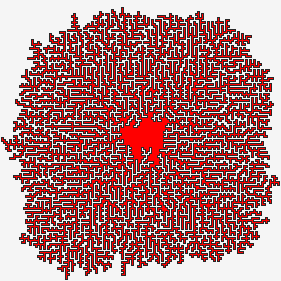
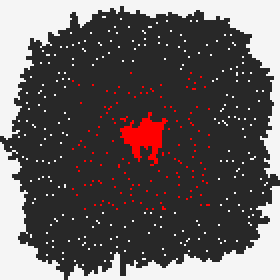

In [71]:
_ = day10a(puzzle.input, part2=True, visualize=True)

In [72]:
def day10b(s, *, part2=False):  # Concise implementation.
  grid = np.array([list(line) for line in s.splitlines()])
  ((y, x),) = np.argwhere(grid == 'S')
  assert grid[y + 1, x] in 'JL|'  # The start has a downward loop arm in all the examples I see.
  dy, dx = 1, 0
  loop: list[tuple[int, int]] = []
  while (ch := grid[y, x]) != 'S' or not loop:
    loop.append((y, x))
    dy, dx = (dx, dy) if ch in 'L7' else (-dx, -dy) if ch in 'JF' else (dy, dx)
    y, x = y + dy, x + dx

  if not part2:
    return len(loop) // 2

  grid2 = np.full(np.array(grid.shape) * 2 + 1, 1, np.uint8)
  for (y0, x0), (y1, x1) in itertools.pairwise(loop + [loop[0]]):
    grid2[y0 * 2 + 1, x0 * 2 + 1] = grid2[y0 + y1 + 1, x0 + x1 + 1] = 0

  skimage.segmentation.flood_fill(grid2, (0, 0), 0, in_place=True)
  return np.count_nonzero(grid2[1::2, 1::2])


check_eq(day10b(s1), 8)
check_eq(day10b(s2), 4)
puzzle.verify(1, day10b)

day10b_part2 = functools.partial(day10b, part2=True)
check_eq(day10b_part2(s3), 4)
check_eq(day10b_part2(s4), 4)
check_eq(day10b_part2(s5), 8)
check_eq(day10b_part2(s6), 10)
puzzle.verify(2, day10b_part2)

(Part 1: 0.008 s)
(Part 2: 0.015 s)


In [73]:
def day10(s, *, part2=False):  # Interior test using row intersection counting.
  grid = np.pad([list(line) for line in s.splitlines()], 1, constant_values='.')
  ((y, x),) = np.argwhere(grid == 'S')
  assert grid[y + 1, x] in 'JL|'  # The start has a downward loop arm in all the examples I see.
  dy, dx = 1, 0
  loop: list[tuple[int, int]] = []
  while (ch := grid[y, x]) != 'S' or not loop:
    loop.append((y, x))
    dy, dx = (dx, dy) if ch in 'L7' else (-dx, -dy) if ch in 'JF' else (dy, dx)
    y, x = y + dy, x + dx
  grid[y, x] = ('|F', '7')[grid[y, x - 1] in 'LF-'][grid[y, x + 1] in 'J7-']  # Replace 'S'.

  if not part2:
    return len(loop) // 2

  loop_mask = np.full(grid.shape, False)
  loop_mask[tuple(np.array(loop).T)] = True
  lookup = np.array([chr(i) in '|LJ' for i in range(256)])  # (Or "in '|F7'".)
  assert grid.dtype == 'U1' and grid.dtype.itemsize == np.dtype(np.uint32).itemsize
  is_wall = lookup[grid.view(np.uint32)]
  is_wall[~loop_mask] = 0
  count = is_wall.cumsum(1) % 2
  count[loop_mask] = 0
  return count.sum()


check_eq(day10(s1), 8)
check_eq(day10(s2), 4)
puzzle.verify(1, day10)

day10_part2 = functools.partial(day10, part2=True)
check_eq(day10_part2(s3), 4)
check_eq(day10_part2(s4), 4)
check_eq(day10_part2(s5), 8)
check_eq(day10_part2(s6), 10)
puzzle.verify(2, day10_part2)

(Part 1: 0.008 s)
(Part 2: 0.010 s)


<a name="day11"></a>
## Day 11: Expanding galaxy distances

- Part 1: Expand the universe, then find the length of the shortest path between every pair of galaxies.  What is the sum of these lengths?

- Part 2: Make each empty row or column one million times larger.  What is the sum of the lengths of all shortest paths?

---

Several approaches are explored:

- **day11a**: Iterate over the initial grid to identify empty rows/cols and expand these.
  Find the locations of all galaxies in the expanded grid and sum all their distances.
  This is only tractable for Part 1.

- **day11b**: Determine the sets of empty rows and columns by iterating over the grid.
  Iterate over all pairs of galaxies and sum their distances (modified by these sets).

- **day11c**: Determine the sets of occupied rows and columns by iterating over the galaxies.
  Iterate over all pairs of galaxies and sum their distances (modified by these sets).

- **day11d**: Compute the sum of distances between all pairs of galaxies in the unexpanded grid.
  Iterate over the grid to identify empty rows and columns.
  For each such empty line, add an expansion penalty between all galaxies before the line
  and all galaxies after the line.

- **day11e**: Determine the sets of empty rows and columns by iterating over the grid.
  Adjust the positions of the galaxies to account for expansion.
  Sum distances between all galaxies using these adjusted coordinates.

- **day11**: Determine the coordinates of the galaxies.
  Traverse the ordered sequence of `y` coordinates using `itertools.groupby`.
  For each group, account for the lengths of all the graph edges in the gap from the prior group.
  Then repeat the process on the ordered sequence of `x` coordinates.
  This is the fastest for both Part1 and part2.

In [74]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2023/day/11), `puzzle.input` has 140 lines:

................................................................................ ... ...............#......#............
...................#.........#...............................................#.. ... ..#............................#...
............#.............................................#..................... ... ...................................
.......#...............#...........#.............#.............................. ... .......#..................#........
..................................................................#............. ... ..................................#
................................................................................ ... ...........#.......................
....#...........#.............................................#................. ... ...................................
................................................................................ ... ...................................
 ...
........#..................

The stored answers are: `{1: '10885634', 2: '707505470642'}`

In [75]:
s1 = """\
...#......
.......#..
#.........
..........
......#...
.#........
.........#
..........
.......#..
#...#.....
"""

In [76]:
def day11a(s):  # Expand empty rows/cols before finding galaxies.  Only for Part 1.
  grid = np.array([list(line) for line in s.splitlines()])

  def expand(grid):
    rows = []
    for row in grid:
      rows.append(row)
      if all(row == '.'):
        rows.append(row)
    return np.array(rows)

  grid = expand(grid)
  grid = expand(grid.T).T
  galaxies = np.argwhere(grid == '#')

  total = 0
  for g1, g2 in itertools.combinations(galaxies, 2):
    total += abs(g1[0] - g2[0]) + abs(g1[1] - g2[1])

  return total


check_eq(day11a(s1), 374)
puzzle.verify(1, day11a)

(Part 1: 0.036 s)


In [77]:
def day11b(s, *, part2=False, growth=1_000_000):  # Using sets of empty rows/cols.
  grid = np.array([list(line) for line in s.splitlines()])
  galaxies = np.argwhere(grid == '#')
  growth = growth - 1 if part2 else 1
  emptys = []
  for _ in range(2):
    emptys.append({i for i, row in enumerate(grid) if all(row == '.')})
    grid = grid.T

  total = 0
  for g1, g2 in itertools.combinations(galaxies, 2):
    for a, b, empty in zip(g1, g2, emptys):
      total += abs(a - b) + growth * len(set(range(min(a, b) + 1, max(a, b))) & empty)

  return total


check_eq(day11b(s1), 374)
puzzle.verify(1, day11b)

day11b_part2 = functools.partial(day11b, part2=True)
check_eq(day11b_part2(s1, growth=10), 1030)
check_eq(day11b_part2(s1, growth=100), 8410)
puzzle.verify(2, day11b_part2)

(Part 1: 0.295 s)
(Part 2: 0.292 s)


In [78]:
def day11c(s, *, part2=False):  # Using sets of occupied rows/cols.  Most concise but slow.
  growth = 999_999 if part2 else 1
  grid = np.array([list(line) for line in s.splitlines()])
  galaxies = np.argwhere(grid == '#')
  occupied = [{galaxy[c] for galaxy in galaxies} for c in range(2)]

  total = 0
  for galaxy1, galaxy2 in itertools.combinations(galaxies, 2):
    for a, b, occ in zip(galaxy1, galaxy2, occupied):
      total += abs(a - b) + growth * len(set(range(min(a, b), max(a, b))) - occ)

  return total


check_eq(day11c(s1), 374)
puzzle.verify(1, day11c)

day11c_part2 = functools.partial(day11c, part2=True)
puzzle.verify(2, day11c_part2)

(Part 1: 0.501 s)
(Part 2: 0.502 s)


In [79]:
def day11d(s, *, part2=False):  # Outer loop over empty rows/cols.
  growth = 999_999 if part2 else 1
  grid = np.array([list(line) for line in s.splitlines()])
  galaxies = np.argwhere(grid == '#')

  all_g1_g2 = itertools.combinations(galaxies, 2)
  total = sum(abs(a - b) for g1, g2 in all_g1_g2 for a, b in zip(g1, g2))

  for c in range(2):
    for i, row in enumerate(grid):
      if all(row == '.'):
        num_before = sum(1 for galaxy in galaxies if galaxy[c] < i)
        total += growth * num_before * (len(galaxies) - num_before)
    grid = grid.T

  return total


check_eq(day11d(s1), 374)
puzzle.verify(1, day11d)

day11d_part2 = functools.partial(day11d, part2=True)
puzzle.verify(2, day11d_part2)

(Part 1: 0.082 s)
(Part 2: 0.081 s)


In [80]:
def day11e(s, *, part2=False):  # Adjust galaxy positions and sum all distances.
  # Adapted from https://github.com/lkesteloot/advent-of-code/blob/master/2023/11.py
  expand = 1_000_000 if part2 else 2
  lines = s.splitlines()
  width, height = len(lines[0]), len(lines)
  galaxies = [(y, x) for y in range(height) for x in range(width) if lines[y][x] == '#']

  missing_y = set(range(height)) - set(y for y, x in galaxies)
  missing_x = set(range(width)) - set(x for y, x in galaxies)

  def adjust(x, missing):
    return x + sum(expand - 1 for v in missing if v < x)

  galaxies = [(adjust(p[0], missing_y), adjust(p[1], missing_x)) for p in galaxies]
  all_g1_g2 = itertools.combinations(galaxies, 2)
  return sum(abs(g1[0] - g2[0]) + abs(g1[1] - g2[1]) for g1, g2 in all_g1_g2)


check_eq(day11e(s1), 374)
puzzle.verify(1, day11e)

day11e_part2 = functools.partial(day11e, part2=True)
puzzle.verify(2, day11e_part2)

(Part 1: 0.013 s)
(Part 2: 0.013 s)


In [81]:
def day11(s, *, part2=False):  # Fastest, using itertools.groupby() on each coordinate.
  expand = 1_000_000 if part2 else 2
  grid = np.array([list(line) for line in s.splitlines()])
  coords = np.argwhere(grid == '#').T  # (The y values in coords[0] are in sorted order.)

  def process(values):
    total = last_value = num = 0
    for value, group in itertools.groupby(values):
      spacing = 1 + (value - last_value - 1) * expand
      total += num * (len(values) - num) * spacing
      num += len(list(group))
      last_value = value
    return total

  return process(coords[0]) + process(sorted(coords[1]))


check_eq(day11(s1), 374)
puzzle.verify(1, day11)

day11_part2 = functools.partial(day11, part2=True)
puzzle.verify(2, day11_part2)

(Part 1: 0.003 s)
(Part 2: 0.002 s)


<a name="day12"></a>
## Day 12: Count of wildcard matches

- Part 1: For each row, count all of the different arrangements of operational and broken springs that meet the given criteria. What is the sum of those counts?

- Part 2: Replace the list of spring conditions with five copies of itself (separated by `?`) and replace the list of contiguous groups of damaged springs with five copies of itself (separated by `,`).  What is the total number of different arrangements?

---

- My initial approach **day12a** is to recursively explore all possible parsings of the string from left to right.
  Each invocation of the recursive function consumes either a space character `'.'` or a whole word, e.g. `'###'`.
  A key to efficiency is to introduce `functools.cache` to reuse any intermediate results;
  this effectively provides dynamic programming with little effort.

- **day12b** also uses a recursive function but parses one character at a time.

- The approach in **day12c** by @lkesteloot simulates a parallel state machine as each character is parsed one at a time.

- The approach **day12d** recognizes that the state can be captured as just two integers:
  the numbers of characters processed and the *number* of counts processed.
  This leads to a *dynamic programming* algorithm over a 2D integer matrix.

- The fastest implementation **day12** is a numba-accelerated version of that dynamic programming algorithm.

- The implementation **day12e** precomputes the possible locations of words, but it is no faster.

In [82]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2023/day/12), `puzzle.input` has 1_000 lines:

??????#??#?? 1,1,5,1
?#?#??##?#? 2,5,1
????????.?#???#??##? 2,1,2,1,1,6
#???#?????.?#?. 2,1,2,1
?##..?#?#?? 2,4
..#??##????###????#? 6,8
???#..?#?? 1,1,2
.#????#?.??? 3,2
 ...
#?#?#???????.? 3,8
?.#????????.?.??.#. 1,7,1,1,1
???????#????.?#. 10,2
??.?????#? 1,5


The stored answers are: `{1: '6488', 2: '815364548481'}`

In [83]:
s1 = """\
***.### 1,1,3
.**..**...*##. 1,1,3
*#*#*#*#*#*#*#* 1,3,1,6
****.#...#... 4,1,1
****.######..#####. 1,6,5
*###******** 3,2,1
""".replace(
    '*', '?'
)

In [84]:
def day12a(s0, *, part2=False, speedup=True):  # Recursively eat either a space or a word.
  @functools.cache
  def num_matches(s, counts):
    if not s:
      return 0 if counts else 1
    if speedup and len(s) < len(counts) + sum(counts):
      return 0
    num = num_matches(s[1:], counts) if s[0] != '#' else 0
    if counts:
      n = counts[0]
      if s[:n].replace('?', '#') == '#' * n and s[n] != '#':
        num += num_matches(s[n + 1 :], counts[1:])
    return num

  total = 0
  for line in s0.splitlines():
    s, right = line.split()
    counts = tuple(map(int, right.split(',')))
    if part2:
      s = '?'.join([s] * 5)
      counts *= 5
    total += num_matches(s + '.', counts)

  return total


check_eq(day12a(s1), 21)
puzzle.verify(1, day12a)

day12a_part2 = functools.partial(day12a, part2=True)
check_eq(day12a_part2(s1), 525152)
puzzle.verify(2, day12a_part2)

(Part 1: 0.007 s)
(Part 2: 0.106 s)


In [85]:
def day12b(s0, *, part2=False, speedup=True):  # Recursively eat one character at a time.
  @functools.cache
  def compute(s, expect, counts):
    if not s:
      return 0 if counts else 1
    if speedup and len(s) < len(counts) + sum(counts) - 1:
      return 0
    num = 0
    if s[0] != '#' and expect != '#':
      num += compute(s[1:], '?', counts)
    if s[0] != '.' and expect != '.' and counts:
      if new_count := counts[0] - 1:
        num += compute(s[1:], '#', (new_count,) + counts[1:])
      else:
        num += compute(s[1:], '.', counts[1:])
    return num

  total = 0
  for line in s0.splitlines():
    s, right = line.split()
    counts = tuple(map(int, right.split(',')))
    if part2:
      s = '?'.join([s] * 5)
      counts *= 5
    total += compute(s, '?', counts)

  return total


check_eq(day12b(s1), 21)
puzzle.verify(1, day12b)

day12b_part2 = functools.partial(day12b, part2=True)
check_eq(day12b_part2(s1), 525152)
puzzle.verify(2, day12b_part2)

(Part 1: 0.015 s)
(Part 2: 0.268 s)


In [86]:
def day12c(s, *, part2=False, speedup=True):  # Parallel state machine.
  # From https://github.com/lkesteloot/advent-of-code/blob/master/2023/12.py
  total = 0
  for line in s.splitlines():
    pattern, counts = line.split()
    if part2:
      pattern = '?'.join([pattern] * 5)
      counts = ','.join([counts] * 5)

    counts = tuple(map(int, counts.split(',')))
    states = {(counts, '?'): 1}  # (counts, expect) -> num.

    for i, ch in enumerate(pattern):
      new_states = collections.defaultdict[tuple[tuple[int, ...], str], int](int)
      for (counts, expect), num in states.items():
        if ch != '.' and expect != '.' and counts:
          new_count = counts[0] - 1
          key = ((new_count,) + counts[1:], '#') if new_count > 0 else (counts[1:], '.')
          new_states[key] += num
        if ch != '#' and expect != '#':
          if speedup and len(pattern) - i < len(counts) + sum(counts):
            continue
          new_states[counts, '?'] += num

      states = new_states

    total += sum(num for (counts, _), num in states.items() if not counts)

  return total


check_eq(day12c(s1), 21)
puzzle.verify(1, day12c)

day12c_part2 = functools.partial(day12c, part2=True)
check_eq(day12c_part2(s1), 525152)
puzzle.verify(2, day12c_part2)

(Part 1: 0.025 s)
(Part 2: 0.237 s)


In [87]:
def day12d(s0, *, part2=False):  # Dynamic programming, without numba.
  total = 0

  for line in s0.splitlines():
    s, right = line.split()
    counts = tuple(map(int, right.split(',')))
    if part2:
      s = '?'.join([s] * 5)
      counts *= 5

    s += '.'
    # Dynamic programming over the string position and the counts position.
    num_matches = np.zeros((len(s) + 1, len(counts) + 1), int)
    num_matches[0, 0] = 1

    for s_index, ch in enumerate(s):
      for counts_index in range(len(counts) + 1):
        if num := num_matches[s_index, counts_index]:
          if ch != '#':
            num_matches[s_index + 1, counts_index] += num
          if counts_index < len(counts):
            n = counts[counts_index]
            if s[s_index : s_index + n].replace('?', '#') == '#' * n and s[s_index + n] != '#':
              num_matches[s_index + n + 1, counts_index + 1] += num

    total += num_matches[-1, -1]

  return total


check_eq(day12d(s1), 21)
puzzle.verify(1, day12d)

day12d_part2 = functools.partial(day12d, part2=True)
check_eq(day12d_part2(s1), 525152)
puzzle.verify(2, day12d_part2)

(Part 1: 0.018 s)
(Part 2: 0.248 s)


In [88]:
# Dynamic programming with precomputed valid word locations.  No faster than the next one.
@numba.njit
def day12e_num_matches(s, counts):
  # Find valid start of words [s_index, count]:
  valid = np.full((len(s) + 1, max(counts) + 1), False)
  valid[:-2, 1] = (s[:-1] != ord('.')) & (s[1:] != ord('#'))
  for s_index in range(len(s) - 1, -1, -1):
    if s[s_index] != ord('.'):
      valid[s_index, 2:] = valid[s_index + 1, 1:-1]

  # Dynamic programming to count the number of matches [s_index, counts_index]:
  num_matches = np.zeros((len(s) + 1, len(counts) + 1), np.int64)
  num_matches[0, 0] = 1
  for s_index, ch in enumerate(s):
    for counts_index in range(len(counts) + 1):
      num = num_matches[s_index, counts_index]
      if num:
        if ch != ord('#'):
          num_matches[s_index + 1, counts_index] += num
        if counts_index < len(counts):
          n = counts[counts_index]
          if s_index + n < len(s) and s[s_index + n] != ord('#'):
            matches_word = True
            for i in range(s_index, s_index + n):
              if s[i] == ord('.'):
                matches_word = False
                break
            if matches_word:
              num_matches[s_index + n + 1, counts_index + 1] += num

  return num_matches[-1, -1]


def day12e(s0, *, part2=False):
  total = 0
  for line in s0.splitlines():
    s, right = line.split()
    counts = tuple(map(int, right.split(',')))
    if part2:
      s = '?'.join([s] * 5)
      counts *= 5
    s_array = np.array([ord(ch) for ch in list(s + '.')], np.uint8)
    total += day12e_num_matches(s_array, np.array(counts))
  return total


check_eq(day12e(s1), 21)
puzzle.verify(1, day12e)

day12e_part2 = functools.partial(day12e, part2=True)
check_eq(day12e_part2(s1), 525152)
puzzle.verify(2, day12e_part2)

(Part 1: 0.003 s)
(Part 2: 0.010 s)


In [89]:
# Fastest using dynamic programming and numba (but ugly).
@numba.njit
def day12_num_matches(s, counts):
  num_matches = np.zeros((len(s) + 1, len(counts) + 1), np.int64)
  num_matches[0, 0] = 1

  for s_index, ch in enumerate(s):
    for counts_index in range(len(counts) + 1):
      num = num_matches[s_index, counts_index]
      if num:
        if ch != ord('#'):
          num_matches[s_index + 1, counts_index] += num
        if counts_index < len(counts):
          n = counts[counts_index]
          if s_index + n < len(s) and s[s_index + n] != ord('#'):
            matches_word = True
            for i in range(s_index, s_index + n):
              if s[i] == ord('.'):
                matches_word = False
                break
            if matches_word:
              num_matches[s_index + n + 1, counts_index + 1] += num

  return num_matches[-1, -1]


def day12(s0, *, part2=False):
  total = 0
  for line in s0.splitlines():
    s, right = line.split()
    counts = tuple(map(int, right.split(',')))
    if part2:
      s = '?'.join([s] * 5)
      counts *= 5
    s_array = np.array([ord(ch) for ch in list(s + '.')], np.uint8)
    total += day12_num_matches(s_array, np.array(counts))
  return total


check_eq(day12(s1), 21)
puzzle.verify(1, day12)

day12_part2 = functools.partial(day12, part2=True)
check_eq(day12_part2(s1), 525152)
puzzle.verify(2, day12_part2)

(Part 1: 0.003 s)
(Part 2: 0.009 s)


In [90]:
# Failed attempts to improve computation times:
# if len(s) >= n + 1 and all(ch in '#?' for ch in s[1:n]) and s[n] in '.?':  # Slower.
#   return 0
# if len(s) >= n + 1 and s[:n].replace('?', '#') == '#' * n and s[n] in '.?':  # Slower.
#   return 0
# while s and s[0] == '.':  # Slower
#   s = s[1:]
# if len(s) - s.count('.') < sum(counts):  # Slower.
#   return 0
# if s.count('#') > sum(counts):  # Slower.
#   return 0
# s = re.sub(r'\.\.*', '.', s)  # No improvement.

<a name="day13"></a>
## Day 13: Reflection axes in matrices

- Part 1: For each of the patterns, add up the number of columns to the left of each vertical line of reflection; to that, also add 100 multiplied by the number of rows above each horizontal line of reflection.  What is the sum?

- Part 2: In each pattern, you'll need to locate and fix the one smudge that causes a different reflection line to be valid.  What number do you get after summarizing the new reflection line in each pattern in your notes?

---

The brute-force algorithm is easy to express using `numpy` and is fast.

In [91]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2023/day/13), `puzzle.input` has 1_349 lines:

...##....
.#.##.#..
.#....#..
.##..##..
...##....
..####.##
#..##..##

 ...
..##..##...#.
#.#.###...##.
.#..#...#.#..
....##.#...#.


The stored answers are: `{1: '30518', 2: '36735'}`

In [92]:
s1 = """\
#.##..##.
..#.##.#.
##......#
##......#
..#.##.#.
..##..##.
#.#.##.#.

#...##..#
#....#..#
..##..###
#####.##.
#####.##.
..##..###
#....#..#
"""

In [93]:
def day13(s, *, part2=False):
  num_diff = 1 if part2 else 0
  total = 0

  for section in s.split('\n\n'):
    grid = np.array([list(line) for line in section.splitlines()])

    reflections = []
    for axis in range(2):
      for i in range(1, len(grid)):
        h = min(i, len(grid) - i)  # Shortest height.
        if np.sum(grid[i - h : i] != grid[i : i + h][::-1]) == num_diff:
          reflections.append((axis, i))
      grid = grid.T

    ((axis, i),) = reflections
    total += i * [100, 1][axis]

  return total


check_eq(day13(s1), 405)
puzzle.verify(1, day13)

day13_part2 = functools.partial(day13, part2=True)
check_eq(day13_part2(s1), 400)
puzzle.verify(2, day13_part2)

(Part 1: 0.011 s)
(Part 2: 0.011 s)


day13

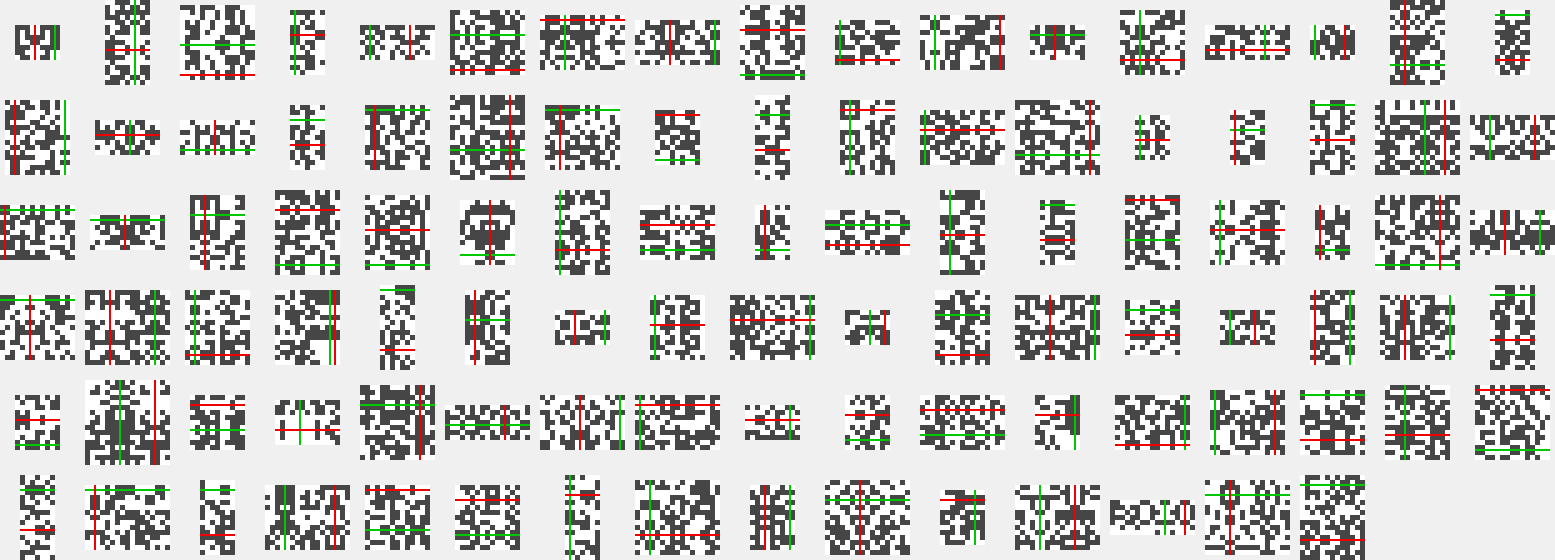

In [94]:
def day13_visualize(s, rep=5):
  images = []

  for section in s.split('\n\n'):
    grid = np.array([list(line) for line in section.splitlines()])
    image = hh.to_image(grid == '#', 70, 255).repeat(rep, 0).repeat(rep, 1)

    for part in range(2):
      for unused_axis in range(2):
        for i in range(1, len(grid)):
          h = min(i, len(grid) - i)  # Shortest height.
          if np.sum(grid[i - h : i] != grid[i : i + h][::-1]) == part:
            color = [(0, 200, 0), (240, 0, 0)][part]
            image[i * rep - 1 : i * rep + 1] = color
        grid = grid.T
        image = np.moveaxis(image, 0, 1)

    images.append(image)

  assembled_image = hh.assemble_arrays(images, (-1, 17), background=240, spacing=rep * 2)
  media.show_image(assembled_image, title='day13')


day13_visualize(puzzle.input)

<a name="day14"></a>
## Day 14: Tilting platform

- Part 1: The rounded rocks (O) will roll when the platform is tilted, while the cube-shaped rocks (#) will stay in place.  Tilt the platform so that the rounded rocks all roll north.  The amount of load caused by a single rounded rock (O) is equal to the number of rows from the rock to the south edge of the platform, including the row the rock is on.  What is the total load?

- Part 2: Each cycle tilts the platform four times so that the rounded rocks roll north, then west, then south, then east.  Run the spin cycle for 1000000000 cycles.  Afterward, what is the total load?

---



In [95]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2023/day/14), `puzzle.input` has 100 lines:

#....#O##.....O.#...##...#OO.....##...#O...O..........OO......#..OO..O.O...O.O#O#..O...#.......O...#
O.....O#..O#O...OO.#.....O#.....O.O..O.O..O.O#.O.#...#...O.#.........#..#O.#......#O.O...#..#.##.##.
......##..#.O#..#.O.O......#.O#..O....#.#..#...#.O.#....#....O.#...#O#OOO.##...O............OO#.#..#
.OO.................#.#.O.#O.O.#...#..........##.O..#.O##..##O......#O...#.#...O...#......O.........
#.......O#...#.OO.##.O.......#...O......O#......#..#.#..O...##..O#..#O.O.....#..OO..O.O.....O.....O#
.O..O.OO...#...#O####...##.O.#..O......#O.O..O......O.......O....O....#..O...O.....OOO..#...O.....OO
OO.#O.....#.O.#O.#OOO...OO#.........#..O.#O.#O..##O...#.##..#.....#...#.....O...O...............O.OO
...OO..#....O.#O.....#.#.#..O...O.#....#....#O...O.........O..##O....O#.O.......OO#.O.O..O......OO..
 ...
.O.O..#OO..O..O.O.........##..O...........OO..O.O.....OO...O#.#.......#...O#O...#..O.O...O.O#...#...
O.....#O.......O#..O..O..##O..#.......#...#.O......O...O..#...O..O..OO.#O..O..O.#.....

The stored answers are: `{1: '108144', 2: '108404'}`

In [96]:
s1 = """\
O....#....
O.OO#....#
.....##...
OO.#O....O
.O.....O#.
O.#..O.#.#
..O..#O..O
.......O..
#....###..
#OO..#....
"""

In [97]:
def day14a(s, *, part2=False, num=1_000_000_000):  # Compact but slow.
  grid = np.rot90(np.array([list(line) for line in s.splitlines()]))  # North is left.

  def slide_left():
    for row in grid:
      open = 0
      for x, ch in enumerate(row):
        if ch == '.':
          pass
        elif ch == 'O':
          if open < x:
            row[open], row[x] = 'O', '.'
          open += 1
        else:
          open = x + 1

  if not part2:
    slide_left()

  else:
    configs: dict[Any, int] = {}  # hashed_grid -> index.
    period = -1
    index = 0
    while True:
      if period < 0:
        if (prev_index := configs.setdefault(grid.tobytes(), index)) != index:
          period = index - prev_index
          hh.display_html(f'At {index=}, found cycle with {period=}.')
          index = num - (num - index) % period
      if index == num:
        break
      for _ in range(4):
        slide_left()
        grid = np.rot90(grid, -1)
      index += 1

  return sum(len(grid[0]) - x for _, x in np.argwhere(grid == 'O'))


check_eq(day14a(s1), 136)
puzzle.verify(1, day14a)

day14a_part2 = functools.partial(day14a, part2=True)
check_eq(day14a_part2(s1), 64)
puzzle.verify(2, day14a_part2)

(Part 1: 0.004 s)


(Part 2: 0.876 s)


day14

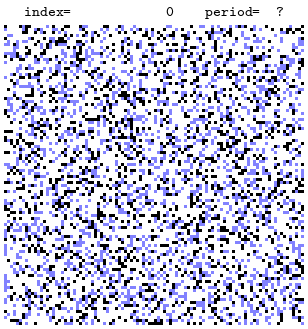

In [98]:
def day14_part2_visualize(s, num=1_000_000_000):
  grid = np.rot90(np.array([list(line) for line in s.splitlines()]))  # North is left.
  images = []

  def slide_left_just_once():
    num_moved = 0
    for row in grid:
      for x, ch in enumerate(row[1:], 1):
        if ch == 'O' and row[x - 1] == '.':
          row[x - 1], row[x] = 'O', '.'
          num_moved += 1
    return num_moved

  def slide_left():
    for row in grid:
      open = 0
      for x, ch in enumerate(row):
        if ch == '.':
          pass
        elif ch == 'O':
          if open < x:
            row[open], row[x] = 'O', '.'
          open += 1
        else:
          open = x + 1

  def add_image(grid, index, period, rep=3):
    image = np.full((*grid.shape, 3), 255, np.uint8)
    image[grid == '#'] = 0
    image[grid == 'O'] = 130, 130, 255
    image = np.rot90(image, -1).repeat(rep, 0).repeat(rep, 1)
    image = hh.pad_array(image, ((25, 4), (4, 4)), (255, 255, 255))
    s_period = '  ?' if period < 0 else f'{period:3}'
    text = f'{index=:13_}    period={s_period}'
    hh.overlay_text(image, (3, image.shape[1] // 2), text, fontsize=15, align='tc')
    images.append(image)

  configs: dict[Any, int] = {}  # hashed_grid -> index.
  period = -1
  index = 0
  while True:
    for _ in range(6 if index < 5 else 6 if index < 10 else 2 if index < 20 else 1):
      add_image(grid, index, period)
    if period < 0:
      if (prev_index := configs.setdefault(grid.tobytes(), index)) != index:
        period = index - prev_index
        index = num - (num - index) % period - period * 2
    if index == num:
      break
    for rotation_index in range(4):
      if index < 1:
        while True:
          add_image(np.rot90(grid, rotation_index), index, period)
          if slide_left_just_once() == 0:
            break
      else:
        slide_left()
        if rotation_index <= 2 and index < 3:
          for _ in range(6):
            add_image(np.rot90(grid, rotation_index), index, period)
      grid = np.rot90(grid, -1)
    index += 1

  images = [images[0]] * 15 + images + [images[-1]] * 40
  media.show_video(images, codec='gif', fps=12, title='day14')


day14_part2_visualize(puzzle.input)

In [99]:
# Precomputed jump tables, array-based and numpy-accelerated.
# Inspired from https://github.com/lkesteloot/advent-of-code/blob/master/2023/14.py, which uses
# lists and dicts and takes 0.4 s.


@numba.njit
def day14b_cycle(rolls, jumps, endpoints, counts, grid_dim):
  for jump, endpoint in zip(jumps, endpoints):
    counts[:] = 0
    for i, (y, x) in enumerate(rolls):
      j = jump[y, x]
      x2 = endpoint[j, 1]
      rolls[i, 1] = x2 + counts[j]
      counts[j] += 1
    # Rotate the coordinates clockwise.
    rolls[:, 0], rolls[:, 1] = rolls[:, 1], grid_dim - 1 - rolls[:, 0]
  # Possibly sort the coordinates here.
  # rolls[:] = np.array(sorted([(y, x) for y, x in rolls]))  # Slow.


def day14b_part2(s, *, num=1_000_000_000, dtype=np.int16):
  grid = np.array([list(line) for line in s.splitlines()])
  grid = np.rot90(grid)  # North is now left.
  rolls = np.argwhere(grid == 'O').astype(dtype)

  jumps0, endpoints0 = [], []
  for unused_axis in range(4):
    jump = np.full(grid.shape, -1, dtype)
    endpoint0: list[tuple[int, int]] = []
    for y, row in enumerate(grid):
      x2 = 0
      for x, ch in enumerate(row):
        if ch == '#':
          x2 = x + 1
        else:
          if not (endpoint0 and endpoint0[-1] == (y, x2)):
            endpoint0.append((y, x2))
          jump[y, x] = len(endpoint0) - 1
    jumps0.append(jump)
    endpoints0.append(np.array(endpoint0))
    grid = np.rot90(grid, -1)

  jumps = hh.stack_arrays(jumps0, align='start')
  endpoints = hh.stack_arrays(endpoints0, align='start')
  counts = np.zeros(endpoints.shape[1], dtype)

  configs: dict[Any, int] = {}  # hashed_rolls -> index.
  period = -1
  index = 0
  while True:
    if period < 0:
      sorted_indices = np.lexsort((rolls[:, 0], rolls[:, 1]))
      sorted_rolls = rolls[sorted_indices]
      config = sorted_rolls.tobytes()
      if (prev_index := configs.setdefault(config, index)) != index:
        period = index - prev_index
        # hh.display_html(f'At {index=}, found cycle with {period=}.')
        index = num - (num - index) % period
    if index == num:
      break
    day14b_cycle(rolls, jumps, endpoints, counts, len(grid))
    index += 1

  return len(rolls) * len(grid[0]) - rolls[:, 1].sum()


check_eq(day14b_part2(s1), 64)
puzzle.verify(2, day14b_part2)

(Part 2: 0.021 s)


In [100]:
# hh.prun(lambda: day14b_part2(puzzle.input))

In [101]:
@numba.njit  # numba is crucial for speed with np.uint8 (not 'U1').
def day14_slide_left(grid):
  for row in grid:
    open = 0
    for x, v in enumerate(row):
      if v == ord('.'):
        pass
      elif v == ord('O'):
        if open < x:
          row[open], row[x] = ord('O'), ord('.')
        open += 1
      else:
        open = x + 1


def day14(s, *, part2=False, num=1_000_000_000):
  grid = np.array([[ord(ch) for ch in line] for line in s.splitlines()], np.uint8)
  grid = np.rot90(grid)  # North is now left.
  grid = np.ascontiguousarray(grid)  # Layout in C-order, for efficient tobytes().

  if not part2:
    day14_slide_left(grid)

  else:
    configs: dict[Any, int] = {}  # hashed_grid -> index.
    period = -1
    index = 0
    while True:
      if period < 0:
        if (prev_index := configs.setdefault(grid.tobytes(), index)) != index:
          period = index - prev_index
          # hh.display_html(f'At {index=}, found cycle with {period=}.')  # 2 ms.
          index = num - (num - index) % period
      if index == num:
        break
      for _ in range(4):
        day14_slide_left(grid)
        grid = np.rot90(grid, -1)
      index += 1

  return sum(len(grid[0]) - x for _, x in np.argwhere(grid == ord('O')))


check_eq(day14(s1), 136)
puzzle.verify(1, day14)

day14_part2 = functools.partial(day14, part2=True)
check_eq(day14_part2(s1), 64)
puzzle.verify(2, day14_part2)

(Part 1: 0.002 s)
(Part 2: 0.016 s)


In [102]:
# hh.prun(lambda: day14(puzzle.input, part2=True))

In [103]:
# Numba is clever enough to jit two different versions of day14_slide_left because the grid view
# is C-contiguous in only 1 of the 4 grid rotations:

# >>> day14_slide_left.signatures
# [(Array(uint8, 2, 'C', False, aligned=True),),
#  (Array(uint8, 2, 'A', False, aligned=True),)]

# Previously:
# [(Array(UnicodeCharSeq(1), 2, 'A', False, aligned=True),),
#  (Array(UnicodeCharSeq(1), 2, 'C', False, aligned=True),)]

# day14_slide_left(np.rot90(np.full((10, 10), ord('.'), np.uint8), 2))
# print(day14_slide_left.signatures)

# config = tuple(sorted(map(tuple, rolls)))
# config = frozenset(tuple(yx) for yx in rolls)
# config = tuple(sorted([(y, x) for y, x in rolls]))

<a name="day15"></a>
## Day 15: Edits to hashed boxes

- Part 1: Run the HASH algorithm on each step in the initialization sequence. What is the sum of the results?

- Part 2: \[Long instructions...\] What is the focusing power of the resulting lens configuration?

---



In [104]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2023/day/15), `puzzle.input` has a single line of 22_785 characters:

tp-,pnm-,vrg-,nfk=6,qqc=2,zs=2,hm-,xnl=4,fszj=6,cx=7,zpfsz-,hdg=9,nqqm-,nfk-,pb- ... =4,sqz=8,ng-,jxxhbv=7,zxm=1,kjzsmv-


The stored answers are: `{1: '504036', 2: '295719'}`

In [105]:
s1 = 'rn=1,cm-,qp=3,cm=2,qp-,pc=4,ot=9,ab=5,pc-,pc=6,ot=7'

In [106]:
def day15(s, *, part2=False):
  s = s.strip()

  def my_hash(s2):
    # return 0 if not s2 else ((my_hash(s2[:-1]) + ord(s2[-1])) * 17) % 256
    h = 0
    for ch in s2:
      h = ((h + ord(ch)) * 17) % 256
    return h

  if not part2:
    return sum(my_hash(instruction) for instruction in s.split(','))

  boxes: list[list[tuple[str, str]]] = [[] for _ in range(256)]
  for instruction in s.split(','):
    label, op, focal = hh.re_groups(r'^(.+)([-=])(.*)$', instruction)
    box_index = my_hash(label)
    if op == '-':
      boxes[box_index] = [(l, f) for l, f in boxes[box_index] if l != label]
    else:
      indices = [i for i, (l, f) in enumerate(boxes[box_index]) if l == label]
      if indices:
        boxes[box_index][indices[0]] = label, focal
      else:
        boxes[box_index].append((label, focal))

  return sum((b + 1) * (i + 1) * int(f) for b in range(256) for i, (l, f) in enumerate(boxes[b]))


check_eq(day15(s1), 1320)
puzzle.verify(1, day15)

day15_part2 = functools.partial(day15, part2=True)
check_eq(day15_part2(s1), 145)
puzzle.verify(2, day15_part2)

(Part 1: 0.001 s)
(Part 2: 0.005 s)


<a name="day16"></a>
## Day 16: Mirrors and splitters

- Part 1: With the beam starting in the top-left heading right, how many tiles end up being energized?

- Part 2: The beam may enter from any edge tile and heading away from that edge.  Find the initial beam configuration that energizes the largest number of tiles; how many tiles are energized in that configuration?

---



In [107]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2023/day/16), `puzzle.input` has 110 lines:

\................\......-.........................../..............|.\..-.................-......../..........
..\................\...........|.|../......\......../../...........|.......\....../.......\....../............
|......|./......../..........|\.......|/..|...............................|...............|...................
...................\.-.............................../.......\.....\..............././.......\...........|....
................\......................|...|\............../........./...................\......./......./....
-......\/..\/../...............................................\....\........\...............-....\......-....
....\......-......................-..|...........................-.|...-..........\................./.........
.......|..........\....|/................................/........................-/.\...-/................../
 ...
....-|.\..|....|............./..........\-.......|........|....|..-................................-./..\\.

The stored answers are: `{1: '7111', 2: '7831'}`

In [108]:
s1 = r"""X
.|...\....X
|.-.\.....X
.....|-...X
........|.X
..........X
.........\X
..../.\\..X
.-.-/..|..X
.|....-|.\X
..//.|....X
""".replace(
    'X', ''
)[
    1:
]

In [109]:
def day16a(s, *, part2=False):  # Initial slow version: (dy, dx), always on stack, no numba.
  grid = np.array([list(line) for line in s.splitlines()])

  def num_visited(start):
    visited = np.full((*grid.shape, 4), False)
    stack = [start]
    while stack:
      y, x, dy, dx = stack.pop()
      if not (0 <= y < grid.shape[0] and 0 <= x < grid.shape[1]):
        continue
      dir = {(0, 1): 0, (0, -1): 1, (1, 0): 2, (-1, 0): 3}[dy, dx]
      if visited[y, x, dir]:
        continue
      visited[y, x, dir] = True
      match grid[y, x]:
        case '\\':
          dy, dx = dx, dy
        case '/':
          dy, dx = -dx, -dy
        case '-':
          if dy != 0:
            dy, dx = 0, 1
            stack.append((y, x, 0, -1))
        case '|':
          if dx != 0:
            dy, dx = 1, 0
            stack.append((y, x, -1, 0))
        case '.':
          pass
        case _:
          assert 0
      y, x = y + dy, x + dx
      stack.append((y, x, dy, dx))
    return visited.any(2).sum()

  part2_starts = (
      [(0, x, 1, 0) for x in range(grid.shape[1])]
      + [(grid.shape[0] - 1, x, -1, 0) for x in range(grid.shape[1])]
      + [(y, 0, 0, 1) for y in range(grid.shape[0])]
      + [(y, grid.shape[1] - 1, 0, -1) for y in range(grid.shape[0])]
  )
  starts = part2_starts if part2 else [(0, 0, 0, 1)]
  return max(num_visited(start) for start in starts)


check_eq(day16a(s1), 46)
puzzle.verify(1, day16a)

day16a_part2 = functools.partial(day16a, part2=True)
check_eq(day16a_part2(s1), 51)
puzzle.verify(2, day16a_part2)

(Part 1: 0.010 s)
(Part 2: 1.788 s)


In [110]:
def day16_visualize(s, *, part2=False, visualize=False, rep=7):
  grid = np.array([list(line) for line in s.splitlines()])

  def create_traced_rays(start, only_last=False):  # start == (y, x, dir); dir 0,1,2,3 == S,E,N,W.
    """Iteratively generate a list of (y, x, dir) and num_visited."""
    visited = np.full((*grid.shape, 4), False)
    rays = [start]
    while rays:
      if not only_last:
        yield rays, visited.any(2).sum()
      new_rays = []
      for y, x, dir in rays:
        y, x = y + (1, 0, -1, 0)[dir], x + (0, 1, 0, -1)[dir]
        if 0 <= y < grid.shape[0] and 0 <= x < grid.shape[1] and not visited[y, x, dir]:
          visited[y, x, dir] = True
          match grid[y, x]:
            case '\\':
              dir = (1, 0, 3, 2)[dir]
            case '/':
              dir = 3 - dir
            case '-':
              if dir in (0, 2):
                dir = 1
                new_rays.append((y, x, 3))
            case '|':
              if dir in (1, 3):
                dir = 0
                new_rays.append((y, x, 2))
          new_rays.append((y, x, dir))
      rays = new_rays
    yield rays, visited.any(2).sum()  # Yield empty final rays.

  def get_num_visited(start):
    return next(create_traced_rays(start, only_last=True))[1]

  part2_starts = (
      [(-1, x, 0) for x in range(grid.shape[1])]
      + [(grid.shape[0], x, 2) for x in range(grid.shape[1])]
      + [(y, -1, 1) for y in range(grid.shape[0])]
      + [(y, grid.shape[1], 3) for y in range(grid.shape[0])]
  )
  starts = part2_starts if part2 else [(0, -1, 1)]
  best_num, best_start = sorted([(get_num_visited(start), start) for start in starts])[-1]

  if visualize:
    h = rep // 2
    line_color = 110, 110, 255
    symbols = {ch: np.full((rep, rep, 3), 255, np.uint8) for ch in list(r'\/-|')}
    symbols['\\'][1:-1, 1:-1][np.eye(rep - 2) > 0] = 0
    symbols['/'][1:-1, 1:-1][np.rot90(np.eye(rep - 2)) > 0] = 0
    symbols['-'][2:-2, 1:-1] = 0, 200, 0
    symbols['|'][1:-1, 2:-2] = 0, 200, 0
    # media.show_images(symbols.values(), border=True, height=100)

    image = np.full((grid.shape[0] * rep, grid.shape[1] * rep, 3), 255, np.uint8)
    for y, x in np.argwhere(grid != '.'):
      image[y * rep : (y + 1) * rep, x * rep : (x + 1) * rep] = symbols[grid[y, x]]
    images = []

    step = 0
    traced_rays = create_traced_rays(best_start)
    rays, num_visited = next(traced_rays)
    time_current, time_interval = 0.7, 0.4
    while rays:
      npix = int(min(time_current - step, 1.0) * rep + 0.5)
      for y, x, dir in rays:
        y0, x0 = y * rep + h, x * rep + h
        y1, x1 = y0 + (1, 0, -1, 0)[dir] * npix, x0 + (0, 1, 0, -1)[dir] * npix
        ya, yb, xa, xb = min(y0, y1), max(y0, y1), min(x0, x1), max(x0, x1)
        image[max(ya, 0) : max(yb + 1, 0), max(xa, 0) : max(xb + 1, 0)] = line_color

      if time_current >= step + 1:
        rays, num_visited = next(traced_rays)
        step += 1
        if rays:
          continue

      time_current += time_interval
      time_interval = min(time_interval + 0.001, 3.0)
      image2 = image.copy()
      for y, x, dir in rays:
        y1, x1 = y * rep + (1, 0, -1, 0)[dir] * npix, x * rep + (0, 1, 0, -1)[dir] * npix
        red = 255, 0, 0
        image2[max(y1 + 2, 0) : max(y1 + rep - 2, 0), max(x1 + 2, 0) : max(x1 + rep - 2, 0)] = red
      if len(grid) > 20:
        text = f'{step=:3}  visited={num_visited:4}'
        hh.overlay_text(image2, (8, 8), text, fontsize=15, margin=4)
      images.append(hh.pad_array(image2, 1, (150,) * 3))

    params: Any = dict(height=len(grid) * 30) if len(grid) < 20 else dict(title='day16a')
    # media.show_image(hh.pad_array(image, 1, (150,) * 3), **params)
    images = [images[0]] * 30 + images + [images[-1]] * 60
    # fps=60 looks great in video viewer, but Chrome cannot keep up for such a large image.
    media.show_video(images, codec='gif', fps=30, **params)

  return best_num


check_eq(day16_visualize(s1), 46)
check_eq(day16_visualize(s1, part2=True), 51)
# check_eq(day16_visualize(s1, part2=True, visualize=True), 51)

if SHOW_BIG_MEDIA:
  puzzle.verify(2, functools.partial(day16_visualize, part2=True, visualize=True))

Cached result:<br/>
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day16a.gif"/><br/>

In [111]:
@numba.njit
def day16_num_visited(grid, start):  # start == (y, x, dir); dir 0,1,2,3 == S,E,N,W.
  visited = np.full((*grid.shape, 4), False)
  stack = [start]
  while stack:
    y, x, dir = stack.pop()
    while 0 <= y < grid.shape[0] and 0 <= x < grid.shape[1] and not visited[y, x, dir]:
      visited[y, x, dir] = True
      match grid[y, x]:
        case 92:  # ord('\\').
          dir = (1, 0, 3, 2)[dir]
        case 47:  # ord('/').
          dir = 3 - dir
        case 45:  # ord('-').
          if dir in (0, 2):
            dir = 1
            stack.append((y, x - 1, 3))
        case 124:  # ord('|').
          if dir in (1, 3):
            dir = 0
            stack.append((y - 1, x, 2))
        case _:
          if visited[y, x, (2, 3, 0, 1)[dir]]:  # Optional tiny speedup.
            break
      y, x = y + (1, 0, -1, 0)[dir], x + (0, 1, 0, -1)[dir]

  return (visited[..., 0] | visited[..., 1] | visited[..., 2] | visited[..., 3]).sum()


def day16(s, *, part2=False):
  grid = np.array([[ord(ch) for ch in line] for line in s.splitlines()], np.uint8)
  part2_starts = (
      [(0, x, 0) for x in range(grid.shape[1])]
      + [(grid.shape[0] - 1, x, 2) for x in range(grid.shape[1])]
      + [(y, 0, 1) for y in range(grid.shape[0])]
      + [(y, grid.shape[1] - 1, 3) for y in range(grid.shape[0])]
  )
  starts = part2_starts if part2 else [(0, 0, 1)]
  return max(day16_num_visited(grid, start) for start in starts)


check_eq(day16(s1), 46)
puzzle.verify(1, day16)

day16_part2 = functools.partial(day16, part2=True)
check_eq(day16_part2(s1), 51)
puzzle.verify(2, day16_part2)

# With numba, switching the grid from dtype 'U1' to np.uint8 reduced the time from 215 ms to 15 ms!

(Part 1: 0.001 s)
(Part 2: 0.014 s)


<a name="day17"></a>
## Day 17: Turn-constrained path

- Part 1: Directing the crucible from the lava pool to the machine parts factory, but not moving more than three consecutive blocks in the same direction, what is the least heat loss it can incur?

- Part 2: Once an ultra crucible starts moving in a direction, it needs to move a minimum of four blocks in that direction before it can turn (or even before it can stop at the end). However, it will eventually start to get wobbly: an ultra crucible can move a maximum of ten consecutive blocks without turning.  What is the least heat loss it can incur?

---



In [112]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2023/day/17), `puzzle.input` has 141 lines:

14322135233443242151311511553152653336263251332436455412763127145257627235231373 ... 52254322415552343132332541225244334
23222412251521323434321323222526653522364245443215776522336263147172722472543351 ... 34363235445634532455243532411134324
43421112342441154333433214263622221665514234422267276122743212611143751574746566 ... 21424313621521641112315143254325312
14223354233244533252445534221641532323126464677532352717545666761562546442574676 ... 15211452313626312115142125311223333
33425323142333522554115415133651421546216444625311551664537752446133134241141373 ... 56124461524131363612211554242414513
32444232153225433111631511261442223347726366525617676446763361246511765476654671 ... 43244534331132523662433244444321335
42531522321251415223425122464634211337747545554736547724343226613114571363572556 ... 42654343546461216251352352125351414
55131424442551342211316642663614311364624477763546322221713276154645323375262475 ... 44411543222654344143155535251111522
 ...
423541143413514123613346122

The stored answers are: `{1: '851', 2: '982'}`

In [113]:
s1 = """\
2413432311323
3215453535623
3255245654254
3446585845452
4546657867536
1438598798454
4457876987766
3637877979653
4654967986887
4564679986453
1224686865563
2546548887735
4322674655533
"""

In [114]:
s2 = """\
111111111111
999999999991
999999999991
999999999991
999999999991
"""

In [115]:
def day17a(s, *, part2=False, visualize=False, rep=2):  # Dijkstra search over "larger" state node.
  grid = np.array([list(line) for line in s.splitlines()], int)
  state = 0, 0, 0, 1, 0  # (y, x, dy, dx, dn).
  target_yx = grid.shape[0] - 1, grid.shape[1] - 1
  distances = {state: 0}
  priority_queue = [(0, state)]
  prev = {}

  while priority_queue:
    distance, state = heapq.heappop(priority_queue)
    y, x, dy, dx, dn = state
    if (y, x) == target_yx and not (part2 and dn < 4):
      break
    for dy2, dx2, same_dir in [(-dx, dy, False), (dy, dx, True), (dx, -dy, False)]:
      dn2 = dn + 1 if same_dir else 1
      if (dn2 <= 10 and (same_dir or dn == 0 or dn >= 4)) if part2 else (dn2 <= 3):
        y2, x2 = y + dy2, x + dx2
        if 0 <= y2 < grid.shape[0] and 0 <= x2 < grid.shape[1]:
          state2 = y2, x2, dy2, dx2, dn2
          distance2 = distance + grid[y2, x2]
          if distance2 < distances.get(state2, 10**9):
            distances[state2] = distance2
            prev[state2] = state
            heapq.heappush(priority_queue, (distance2, state2))
  else:
    raise ValueError('No solution found.')

  if visualize:
    path = [state[:2]]
    while state[:2] != (0, 0):
      state = prev[state]
      path.append(state[:2])
    assert sum(grid[yx] for yx in path[:-1]) == distance

    image = media.to_rgb(grid * 0.9, cmap='gray')  # Or cmap='bwr'.
    image2 = image.copy()
    image2[tuple(np.array(path).T)] = 255, 255, 0
    image = image.repeat(rep, 0).repeat(rep, 1)
    image2 = image2.repeat(rep, 0).repeat(rep, 1)
    title = 'day17b' if part2 else 'day17a'
    media.show_video([image, image2], codec='gif', fps=1, title=title)

  return distance


check_eq(day17a(s1), 102)
puzzle.verify(1, day17a)

day17a_part2 = functools.partial(day17a, part2=True)
check_eq(day17a_part2(s1), 94)
check_eq(day17a_part2(s2), 71)
puzzle.verify(2, day17a_part2)

(Part 1: 0.522 s)
(Part 2: 1.852 s)


day17a

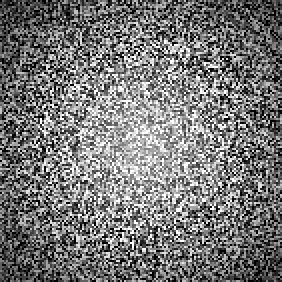

day17b

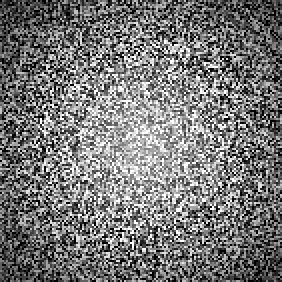

In [116]:
_ = day17a(puzzle.input, visualize=True)
_ = day17a(puzzle.input, part2=True, visualize=True)

In [117]:
@numba.njit  # First numba implementation.
def day17b_compute(grid, part2):
  ny, nx = grid.shape
  state = 0, 0, 0, 1, 0  # (y, x, dy, dx, dn).
  target_yx = ny - 1, nx - 1
  distances = {state: 0}
  priority_queue = [(0, state)]

  while priority_queue:
    distance, state = heapq.heappop(priority_queue)
    y, x, dy, dx, dn = state
    if (y, x) == target_yx and not (part2 and dn < 4):
      break
    for dy2, dx2, same_dir in [(-dx, dy, False), (dy, dx, True), (dx, -dy, False)]:
      dn2 = dn + 1 if same_dir else 1
      if (dn2 <= 10 and (same_dir or dn == 0 or dn >= 4)) if part2 else (dn2 <= 3):
        y2, x2 = y + dy2, x + dx2
        if 0 <= y2 < ny and 0 <= x2 < nx:
          state2 = y2, x2, dy2, dx2, dn2
          distance2 = distance + grid[y2, x2]
          if distance2 < distances.get(state2, 10**9):
            distances[state2] = distance2
            heapq.heappush(priority_queue, (distance2, state2))

  return distance


def day17b(s, *, part2=False):
  grid = np.array([list(line) for line in s.splitlines()], np.uint8)
  return day17b_compute(grid, part2)


puzzle.verify(1, day17b)
puzzle.verify(2, functools.partial(day17b, part2=True))

(Part 1: 1.418 s)
(Part 2: 0.341 s)


In [118]:
@numba.njit  # Faster numba, using flat array, padding, advance min dn.
def day17c_compute(grid, part2, pad):
  ny, nx = grid.shape
  grid_flat = grid.flat
  start_i = pad * nx + pad
  target_i = (ny - 1 - pad) * nx + (nx - 1 - pad)
  dir2s = (1, 3), (2, 0), (3, 1), (0, 2)
  dn2 = 4 if part2 else 1
  offsets = nx, 1, -nx, -1
  distances = {}  # state -> distance with state == (i, dir, dn) with dir 0,1,2,3 == S,E,N,W.
  for dir in range(2):
    distance = 0
    for i in range(1, dn2 + 1):
      distance += grid_flat[start_i + offsets[dir] * i]
    distances[start_i + offsets[dir] * dn2, dir, dn2] = distance
  priority_queue = [(distance, state) for state, distance in distances.items()]

  while priority_queue:
    distance, state = heapq.heappop(priority_queue)
    # distance = distances[state]  # Commenting this line improves runtime.
    i, dir, dn = state
    if i == target_i:
      break
    if dn < (10 if part2 else 3):  # Try going straight.
      i2 = i + offsets[dir]
      state2 = i2, dir, dn + 1
      distance2 = distance + grid_flat[i2]
      if distance2 < distances.get(state2, 30_000):
        distances[state2] = distance2
        heapq.heappush(priority_queue, (distance2, state2))
    for dir2 in dir2s[dir]:  # Try turning left or right.
      i2, distance2, offset = i, distance, offsets[dir2]
      for _ in range(dn2):
        i2 += offset
        distance2 += grid_flat[i2]
      state2 = i2, dir2, dn2
      if distance2 < distances.get(state2, 30_000):
        distances[state2] = distance2
        heapq.heappush(priority_queue, (distance2, state2))

  return distance


def day17c(s, *, part2=False):
  grid = np.array([list(line) for line in s.splitlines()], np.uint16)
  pad = 4 if part2 else 1
  grid = np.pad(grid, pad, constant_values=30_000)
  return day17c_compute(grid, part2, pad)


check_eq(day17c(s1), 102)
puzzle.verify(1, day17c)
day17c_part2 = functools.partial(day17c, part2=True)
check_eq(day17c_part2(s1), 94)
check_eq(day17c_part2(s2), 71)
puzzle.verify(2, day17c_part2)

(Part 1: 0.066 s)
(Part 2: 0.176 s)


In [119]:
# Specializing the numba function based on the parameter part2 has little effect here.
@functools.cache
def day17_get_jitted(part2):
  grid = np.zeros((4, 4), np.uint16)
  _ = grid

  def compute(grid):
    pad = 4 if part2 else 1
    ny, nx = grid.shape
    grid_flat = grid.flat
    start_i = pad * nx + pad
    target_i = (ny - 1 - pad) * nx + (nx - 1 - pad)
    dir2s = (1, 3), (2, 0), (3, 1), (0, 2)
    dn2 = 4 if part2 else 1
    offsets = nx, 1, -nx, -1
    distances = {}  # state -> distance with state == (i, dir, dn) with dir 0,1,2,3 == S,E,N,W.
    for dir in range(2):
      distance = 0
      for i in range(1, dn2 + 1):
        distance += grid_flat[start_i + offsets[dir] * i]
      distances[start_i + offsets[dir] * dn2, dir, dn2] = distance
    priority_queue = [(distance, state) for state, distance in distances.items()]

    while priority_queue:
      distance, state = heapq.heappop(priority_queue)
      # distance = distances[state]  # Commenting this line improves runtime.
      i, dir, dn = state
      if i == target_i:
        break
      if dn < (10 if part2 else 3):  # Try going straight.
        i2 = i + offsets[dir]
        state2 = i2, dir, dn + 1
        distance2 = distance + grid_flat[i2]
        if distance2 < distances.get(state2, 30_000):
          distances[state2] = distance2
          heapq.heappush(priority_queue, (distance2, state2))
      for dir2 in dir2s[dir]:  # Try turning left or right.
        i2, distance2, offset = i, distance, offsets[dir2]
        for _ in range(dn2):
          i2 += offset
          distance2 += grid_flat[i2]
        state2 = i2, dir2, dn2
        if distance2 < distances.get(state2, 30_000):
          distances[state2] = distance2
          heapq.heappush(priority_queue, (distance2, state2))

    return distance

  return numba.njit(compute)

In [120]:
def day17(s, *, part2=False):
  grid = np.array([list(line) for line in s.splitlines()], np.uint16)
  pad = 4 if part2 else 1
  grid = np.pad(grid, pad, constant_values=30_000)
  return day17_get_jitted(part2)(grid)


check_eq(day17(s1), 102)
puzzle.verify(1, day17)
day17_part2 = functools.partial(day17, part2=True)
check_eq(day17_part2(s1), 94)
check_eq(day17_part2(s2), 71)
puzzle.verify(2, day17_part2)

(Part 1: 0.071 s)
(Part 2: 0.185 s)


<a name="day18"></a>
## Day 18: Area inside long loop

- Part 1: How many cubic meters of lava could it hold?

- Part 2: Convert the hexadecimal color codes into the correct instructions; if the Elves follow this new dig plan, how many cubic meters of lava could the lagoon hold?

---

- The first approach **day18a_part1** discretizes the loop path into a 2D grid and applies a flood-fill algorithm.
  This approach is only practical for Part 1.

- The efficient approach **day18** computes the area inside the path by summing signed areas corresponding to the
  Up segments and Down segments.
  However, this basic scheme only accounts for half of the perimeter, whereas we need to include the full perimeter.
  We add extra single-wide path areas on the Down and Right segments to complete the full perimeter.

In [121]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2023/day/18), `puzzle.input` has 638 lines:

R 6 (#4d17d2)
U 5 (#af8603)
L 4 (#1ae700)
U 10 (#653071)
R 4 (#14fa90)
U 7 (#35c823)
L 6 (#c3ab30)
U 5 (#35c821)
 ...
L 7 (#259fe2)
U 8 (#745a53)
L 6 (#c1add2)
U 6 (#1063f3)


The stored answers are: `{1: '40714', 2: '129849166997110'}`

In [122]:
s1 = """\
R 6 (#70c710)
D 5 (#0dc571)
L 2 (#5713f0)
D 2 (#d2c081)
R 2 (#59c680)
D 2 (#411b91)
L 5 (#8ceee2)
U 2 (#caa173)
L 1 (#1b58a2)
U 2 (#caa171)
R 2 (#7807d2)
U 3 (#a77fa3)
L 2 (#015232)
U 2 (#7a21e3)
"""

In [123]:
def day18a_part1(s, *, visualize=False):  # Grid flood-fill approach; slow.
  y, x = 0, 0
  visited = {(y, x)}
  for line in s.splitlines():
    op, s_num, unused_color = hh.re_groups(r'^([LRUD]) (\d+) \(#(......)\)$', line)
    num = int(s_num)
    dy, dx = dict(L=(0, -1), R=(0, 1), U=(-1, 0), D=(1, 0))[op]
    for _ in range(num):
      y, x = y + dy, x + dx
      visited.add((y, x))

  grid = hh.grid_from_indices(visited, pad=1)
  skimage.segmentation.flood_fill(grid, (0, 0), 2, in_place=True)
  if visualize:
    cmap = {0: (170, 200, 255), 1: (0, 80, 0), 2: (245, 245, 245)}
    image = np.array([cmap[e] for e in grid.flat], np.uint8).reshape(*grid.shape, 3)
    media.show_image(image, title='day18a')
  return np.sum(grid != 2)


check_eq(day18a_part1(s1), 62)
puzzle.verify(1, day18a_part1)

(Part 1: 0.007 s)


day18a

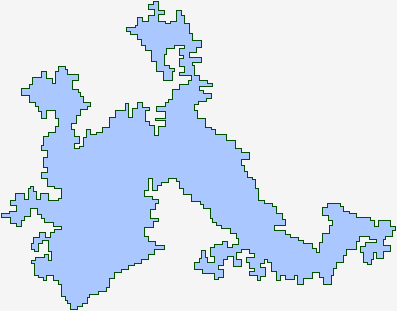

In [124]:
_ = day18a_part1(puzzle.input, visualize=True)

In [125]:
def day18(s, *, part2=False):
  x = 0
  area = 1
  for line in s.splitlines():
    op, s_num, color = hh.re_groups(r'^([LRUD]) (\d+) \(#(......)\)$', line)
    num = int(color[:5], 16) if part2 else int(s_num)
    op = 'RDLU'[int(color[5])] if part2 else op
    # The tricky aspect is that the full perimeter must be included.  If one accounts only for
    # "+- x * num" during the 'D' and 'U' motions, only half the perimeter is accounted for.
    # Adding an extra "num" for the 'R' and 'D' motions corrects this.  (One could equivalently
    # add this extra "num" to 'L' or 'U' because sum(R) == sum(L) and sum(D) == sum(U).)
    match op:
      case 'R':
        x += num
        area += num  # Extra num for the upper perimeter.
      case 'L':
        x -= num
      case 'D':
        area += x * num + num  # Extra num for the right perimeter.
      case 'U':
        area -= x * num

  return area


check_eq(day18(s1), 62)
puzzle.verify(1, day18)

day18_part2 = functools.partial(day18, part2=True)
check_eq(day18_part2(s1), 952408144115)
puzzle.verify(2, day18_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


day18b

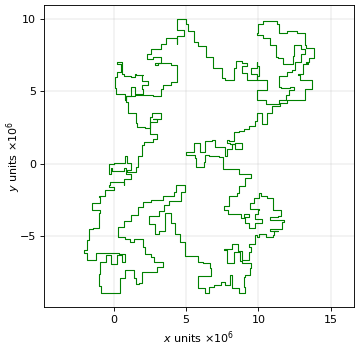

In [126]:
def day18_part2_visualize(s):
  list_yx = [np.array([0, 0])]
  for line in s.splitlines():
    _, _, color = hh.re_groups(r'^([RDLU]) (\d+) \(#(......)\)$', line)
    num = int(color[:5], 16)
    dyx = np.array(((0, 1), (1, 0), (0, -1), (-1, 0))[int(color[5])]) * num
    list_yx.append(list_yx[-1] + dyx)

  assert np.all(list_yx[-1] == (0, 0))
  yxs = np.array(list_yx) / 1e6

  fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
  ax.set_aspect('equal', 'datalim')  # Preserve aspect ratio and get square figure.
  # ax.set_aspect('equal', 'box')  # Preserve aspect ratio and get square figure.
  ax.plot(yxs[:, 1], yxs[:, 0], '-', color='green', linewidth=1.0)
  ax.grid(True, lw=0.25)
  ax.set(xlabel=r'$x$ units $\times 10^6$', ylabel=r'$y$ units $\times 10^6$')
  ax.yaxis.labelpad = -3
  ax.locator_params(nbins=6)  # Reduce the number of ticks and ticklabels.
  # fig.tight_layout()
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  plt.close()
  media.show_image(image, title='day18b')


# day18_part2_visualize(s1)
day18_part2_visualize(puzzle.input)

<a name="day19"></a>
## Day 19: Graph of inequality rules

- Part 1: What do you get if you add together all of the rating numbers for all of the parts that ultimately get accepted?

- Part 2: Each of the four ratings (x, m, a, s) can have an integer value ranging from a minimum of 1 to a maximum of 4000. Of all possible distinct combinations of ratings, how many will be accepted?

---

The approach in Part 2 is to compute using intervals, subdividing them as appropriate based on the inequality conditions.

In [127]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2023/day/19), `puzzle.input` has 766 lines:

vvd{a<3062:hrj,x>1762:zgl,s<881:dlf,A}
ckk{s>862:R,a>3127:A,A}
th{a<3804:jjp,a>3923:mfp,a<3866:ck,fgv}
sm{m>453:A,s<2996:R,A}
gj{x>1334:R,R}
szs{m>3306:A,a<2977:A,A}
hk{m<2759:tbr,s>3402:A,cn}
hrj{s>993:R,R}
 ...
{x=1147,m=354,a=1121,s=1455}
{x=2517,m=2025,a=2242,s=674}
{x=418,m=1394,a=1326,s=405}
{x=1630,m=354,a=226,s=1078}


The stored answers are: `{1: '509597', 2: '143219569011526'}`

In [128]:
# spellcheck=off
s1 = """\
px{a<2006:qkq,m>2090:A,rfg}
pv{a>1716:R,A}
lnx{m>1548:A,A}
rfg{s<537:gd,x>2440:R,A}
qs{s>3448:A,lnx}
qkq{x<1416:A,crn}
crn{x>2662:A,R}
in{s<1351:px,qqz}
qqz{s>2770:qs,m<1801:hdj,R}
gd{a>3333:R,R}
hdj{m>838:A,pv}

{x=787,m=2655,a=1222,s=2876}
{x=1679,m=44,a=2067,s=496}
{x=2036,m=264,a=79,s=2244}
{x=2461,m=1339,a=466,s=291}
{x=2127,m=1623,a=2188,s=1013}
"""
# spellcheck=on

In [129]:
def day19_part1(s):
  s_rules, s_elements = s.split('\n\n')
  rules = {}
  for line in s_rules.splitlines():
    name, s_rules = line[:-1].split('{')
    rules[name] = s_rules.split(',')

  total = 0
  for line in s_elements.splitlines():
    contents = ast.literal_eval(re.sub('([a-z])=', r"'\1':", line))
    name = 'in'
    while name not in {'A', 'R'}:
      for rule in rules[name]:
        if rule.isalpha():
          name = rule
          break
        category, op, s_num, label = hh.re_groups(r'^(\w)([<>])(\d+):(\w+)$', rule)
        current, num = contents[category], int(s_num)
        if (current < num) if op == '<' else (current > num):
          name = label
          break

    if name == 'A':
      total += sum(contents.values())

  return total


check_eq(day19_part1(s1), 19114)
puzzle.verify(1, day19_part1)

(Part 1: 0.005 s)


In [130]:
def day19a_part2(s):  # Implementation using a stack.
  s_rules, _ = s.split('\n\n')
  rules: dict[str, list[str]] = {'R': []}
  for line in s_rules.splitlines():
    name, s_rules = line[:-1].split('{')
    rules[name] = s_rules.split(',')

  total = 0
  initial_intervals = {category: (1, 4001) for category in 'xmas'}  # (start, stop).
  stack = [('in', initial_intervals)]

  while stack:
    name, intervals = stack.pop()
    if name == 'A':
      total += math.prod(stop - start for start, stop in intervals.values())
      continue

    for rule in rules[name]:
      if rule.isalpha():
        stack.append((rule, intervals))
        break

      category, op, s_num, label = hh.re_groups(r'^(\w)([<>])(\d+):(\w+)$', rule)
      num = int(s_num)
      start, stop = intervals[category]

      if op == '<':
        if start < num:
          stack.append((label, intervals | {category: (start, min(stop, num))}))
        start = max(start, num)
      else:
        if stop > num + 1:
          stack.append((label, intervals | {category: (max(start, num + 1), stop)}))
        stop = min(stop, num + 1)

      if start < stop:
        intervals[category] = start, stop
      else:
        break

  return total


check_eq(day19a_part2(s1), 167409079868000)
puzzle.verify(2, day19a_part2)

(Part 2: 0.002 s)


In [131]:
def day19_part2(s):  # Implementation using a recursive function.
  s_rules, _ = s.split('\n\n')
  rules = {}
  for line in s_rules.splitlines():
    name, s_rules = line[:-1].split('{')
    rules[name] = s_rules.split(',')

  def compute(name, intervals):
    if name == 'R' or any(start >= stop for start, stop in intervals.values()):
      return 0
    if name == 'A':
      return math.prod(stop - start for start, stop in intervals.values())

    total = 0
    for rule in rules[name]:
      if rule.isalpha():
        return total + compute(rule, intervals)

      category, op, s_num, label = hh.re_groups(r'^(\w)([<>])(\d+):(\w+)$', rule)
      num = int(s_num)
      start, stop = intervals[category]
      if op == '<':
        total += compute(label, intervals | {category: (start, min(stop, num))})
        intervals[category] = max(start, num), stop
      else:
        total += compute(label, intervals | {category: (max(start, num + 1), stop)})
        intervals[category] = start, min(stop, num + 1)

  return compute('in', {category: (1, 4001) for category in 'xmas'})


check_eq(day19_part2(s1), 167409079868000)
puzzle.verify(2, day19_part2)

(Part 2: 0.003 s)


<a name="day20"></a>
## Day 20: Pulses through graph

- Part 1: Determine the number of low pulses and high pulses that would be sent after pushing the button 1000 times, waiting for all pulses to be fully handled after each push of the button. What do you get if you multiply the total number of low pulses sent by the total number of high pulses sent?

- Part 2: Waiting for all pulses to be fully handled after each button press, what is the fewest number of button presses required to deliver a single low pulse to the module named rx?

---



In [132]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2023/day/20), `puzzle.input` has 58 lines:

%pj -> sh
%mn -> jp
&hf -> rg, vl, tq, qq, mv, zz
%xl -> hf
%sv -> mn, dl
%kk -> lh
&sj -> kz
%jj -> lq, kk
 ...
%fx -> fl, hb
&lq -> bg, kk, dz, xr, lh, fm
%rg -> hf, fb
broadcaster -> xr, mr, rg, sv


The stored answers are: `{1: '944750144', 2: '222718819437131'}`

In [133]:
s1 = """\
broadcaster -> a, b, c
%a -> b
%b -> c
%c -> inv
&inv -> a
"""

In [134]:
s2 = """\
broadcaster -> a
%a -> inv, con
&inv -> b
%b -> con
&con -> output
"""

day20

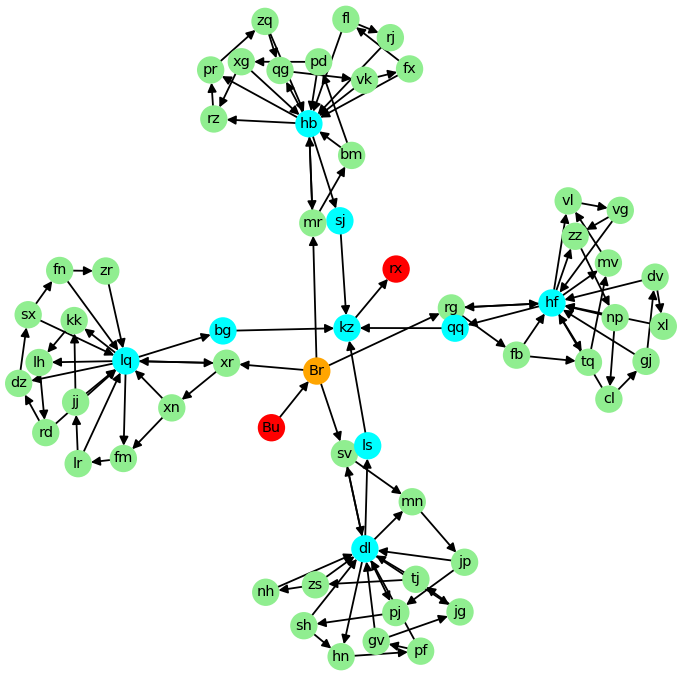

In [135]:
def day20_visualize(s):
  graph = networkx.DiGraph()
  graph.add_node('Bu', node_color='red')
  graph.add_edge('Bu', 'Br')
  graph.add_node('rx', node_color='red')
  for line in s.splitlines():
    ch, name, rhs = hh.re_groups(r'^(.)(\w+) -> (.*)$', line)
    name = {'broadcaster'[1:]: 'Br'}.get(name, name)
    color = {'%': 'lightgreen', '&': 'aqua', 'b': 'orange'}[ch]
    graph.add_node(name, node_color=color)
    for output in rhs.split(', '):
      graph.add_edge(name, output)

  pos = hh.graph_layout(graph, prog='neato')  # prog='dot' is worse.
  # Tweak the layout for my particular input.
  pos['Bu'] = 250, 220
  pos['Br'] = 290, 270
  pos['rx'] = 360, 360

  fig, ax = plt.subplots(figsize=(6, 6), dpi=130)
  ax.axes.set_aspect('equal')
  node_color = [attr for _, attr in graph.nodes(data='node_color')]
  networkx.draw(graph, pos, node_size=200, node_color=node_color, with_labels=True, font_size=8)
  fig.tight_layout(pad=0)
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  media.show_image(image, border=True, title='day20')
  plt.close(fig)


if 'networkx' in globals():
  day20_visualize(puzzle.input)

In [136]:
def day20a(s, *, part2=False, num_buttons=1000):  # Compact.
  all_ch, outputs, flipflop = {}, {}, {}
  inputs = collections.defaultdict[str, dict[str, int]](dict)
  for line in s.splitlines():
    ch, name, rhs = hh.re_groups(r'^(.)(\w+) -> (.*)$', line)
    all_ch[name], outputs[name], flipflop[name] = ch, rhs.split(', '), 0
    for output in outputs[name]:
      inputs[output][name] = 0

  counts = collections.Counter[int]()
  period = {name: 0 for name in inputs[next(iter(inputs['rx']))]} if part2 else {}

  for button_index in range(10**9 if part2 else num_buttons):
    counts[0] += 1
    pulses = collections.deque([('button', 0, 'broadcaster'[1:])])

    while pulses:
      source, value, name = pulses.popleft()
      if name in period and value == 0:
        period[name] = button_index + 1
        if all(period.values()):
          return math.lcm(*period.values())
      match all_ch[name]:
        case '%':
          if value == 1:
            continue
          value = flipflop[name] = 1 - flipflop[name]
        case '&':
          inputs[name][source] = value
          value = 1 - all(inputs[name].values())
      for output in outputs[name]:
        counts[value] += 1
        if output not in {'rx', 'output'}:
          pulses.append((name, value, output))

  return math.prod(counts.values())


check_eq(day20a(s1), 32000000)
check_eq(day20a(s2), 11687500)
puzzle.verify(1, day20a)

day20a_part2 = functools.partial(day20a, part2=True)
puzzle.verify(2, day20a_part2)

(Part 1: 0.019 s)
(Part 2: 0.072 s)


In [137]:
def day20(s, *, part2=False, num_buttons=1000, debug=False):  # Faster.
  all_ch, outputs, flipflop = {}, {}, {}
  inputs = collections.defaultdict[str, dict[str, int]](dict)
  for line in s.splitlines():
    ch, name, rhs = hh.re_groups(r'^(.)(\w+) -> (.*)$', line)
    all_ch[name], outputs[name], flipflop[name] = ch, rhs.split(', '), 0
    for output in outputs[name]:
      inputs[output][name] = 0  # For each conjunction, inputs are initially off.

  if part2:
    (main_nand,) = inputs['rx']
    trigger_indices: dict[str, list[int]] = {name: [] for name in inputs[main_nand]}  # (Length 4.)

    for button_index in itertools.count():
      pulses = collections.deque([('button', 0, 'broadcaster'[1:])])

      while pulses:
        source, value, name = pulses.popleft()
        if name in trigger_indices and value == 0:
          trigger_indices[name].append(button_index + 1)
          all_indices = list(trigger_indices.values())
          if all(len(indices) >= (1 + debug) for indices in all_indices):
            periods = [indices[0] for indices in all_indices]
            if debug:
              assert all(indices[0] * 2 == indices[1] for indices in all_indices)
            return math.lcm(*periods)
            # phases = [indices[-1] for indices in all_indices]
            # return 1 + _solve_modulo_congruences(periods, phases)
        if (ch := all_ch[name]) == '%':
          if value == 1:
            continue
          value = flipflop[name] = 1 - flipflop[name]
        elif ch == '&':
          inputs[name][source] = value
          value = 1 - all(v == 1 for v in inputs[name].values())
        for output in outputs[name]:
          if output != 'rx':
            pulses.append((name, value, output))

  # Part 1.
  counts = collections.Counter[int]()
  for button_index in range(num_buttons):
    if debug:
      print()
    counts[0] += 1  # Initial 'button'.
    pulses = collections.deque([('button', 0, 'broadcaster'[1:])])

    while pulses:
      source, value, name = pulses.popleft()
      if (ch := all_ch[name]) == '%':
        if value == 1:
          continue
        value = flipflop[name] = 1 - flipflop[name]
      elif ch == '&':
        inputs[name][source] = value
        value = 1 - all(inputs[name].values())
      for output in outputs[name]:
        if debug:
          print(f'{ch}{name} -{["low", "high"][value]} -> {output}')
        counts[value] += 1
        if output not in {'output', 'rx'}:
          pulses.append((name, value, output))

  return math.prod(counts.values())


if 0:
  day20(s1, debug=True, num_buttons=2)
  day20(s2, debug=True, num_buttons=4)
check_eq(day20(s1), 32000000)
check_eq(day20(s2), 11687500)
puzzle.verify(1, day20)

day20_part2 = functools.partial(day20, part2=True)
puzzle.verify(2, day20_part2)

(Part 1: 0.019 s)
(Part 2: 0.063 s)


<a name="day21"></a>
## Day 21: Steps through grid lattice

- Part 1: Starting from the garden plot marked S on your map, how many garden plots could the Elf reach in exactly 64 steps?

- Part 2: Starting from the garden plot marked S on your infinite map, how many garden plots could the Elf reach in exactly 26501365 steps?

---



In [138]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2023/day/21), `puzzle.input` has 131 lines:

................................................................................ ... ...................................
....##.#...##..#.......................#.#...###............#..........##....... ... .......#..#..#...........#....#..#.
.#...##.................#.......#....#.#....##..#....##...#...................#. ... ..#...#...###..#.......#...........
........#.#..#..###.......#.......#......#.............####.............#....... ... .................#.......#.#.......
..............#......#..#.................#.##......#..#..................#..#.. ... .#......#....#...#.#........#......
.#..#..#.#.........#....#.....#.........##........#............................. ... #...##..#.....#.#..#..#............
.......##......#....................#.#.....#.........#......................#.. ... ...#..#.......##.......#..#..#.....
...#.....##..#..#.###....#.........#..#...#....##.#.............#.#.#.........#. ... ....#.#................#.#...#.....
 ...
...#.....##...#.....#....#.

The stored answers are: `{1: '3637', 2: '601113643448699'}`

In [139]:
s1 = """\
...........
.....###.#.
.###.##..#.
..#.#...#..
....#.#....
.##..S####.
.##..#...#.
.......##..
.##.#.####.
.##..##.##.
...........
"""

In [140]:
def day21a_part1(s, *, nsteps=64):
  grid = np.array([list(line) for line in s.splitlines()])
  grid = np.pad(grid, 1, constant_values='#')
  (start_yx,) = np.argwhere(grid == 'S')

  active = {tuple(start_yx)}
  for _ in range(nsteps):
    new_active = set()
    for y, x in active:
      for dy, dx in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        yx2 = y + dy, x + dx
        if grid[yx2] != '#':
          new_active.add(yx2)
    active = new_active

  return len(active)


check_eq(day21a_part1(s1, nsteps=6), 16)
puzzle.verify(1, day21a_part1)

(Part 1: 0.105 s)


In [141]:
def day21_part1(s, *, nsteps=64):
  grid = np.array([list(line) for line in s.splitlines()])
  is_empty = grid != '#'
  grid = np.pad(grid, 1, constant_values='#')
  active = grid == 'S'
  for _ in range(nsteps):
    active[1:-1, 1:-1] = is_empty & (
        active[:-2, 1:-1] | active[2:, 1:-1] | active[1:-1, :-2] | active[1:-1, 2:]
    )
  return active.sum()


check_eq(day21_part1(s1, nsteps=6), 16)
puzzle.verify(1, day21_part1)

(Part 1: 0.003 s)


day21a

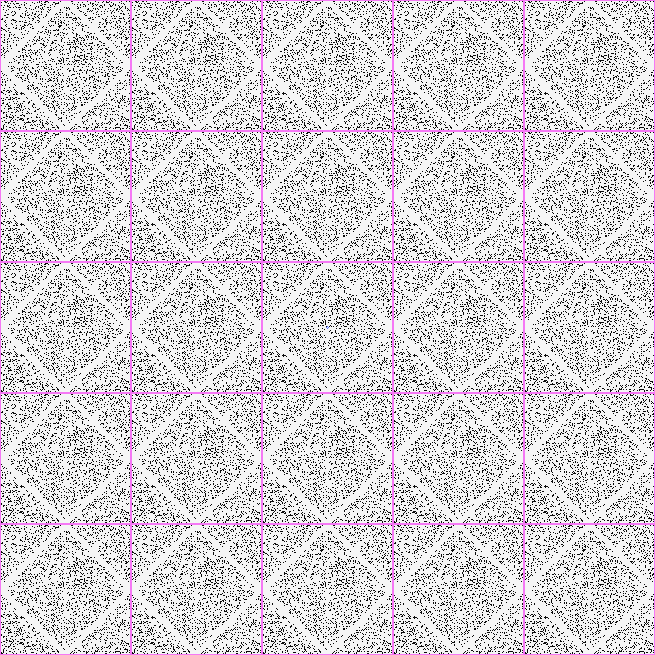

In [142]:
def day21_visualize(s, num_rings=2, no_flicker=True):
  grid = np.array([list(line) for line in s.splitlines()])
  num_tiles = 1 + 2 * num_rings
  grid = np.tile(grid, (num_tiles, num_tiles))
  is_empty = grid != '#'
  active = np.full(np.array(grid.shape) + 2, False)
  active[(1 + 65 + num_rings * 131,) * 2] = True
  counts = np.full((num_tiles, num_tiles), 0)
  images = []
  new_counts = False
  num_indices = 65 + num_rings * 131

  for index in range(num_indices):
    active[1:-1, 1:-1] = is_empty & (
        active[:-2, 1:-1] | active[2:, 1:-1] | active[1:-1, :-2] | active[1:-1, 2:]
    )
    if (index + 1) % 131 == 65 and index > 65:
      counts = active[1:-1, 1:-1].reshape(num_tiles, 131, num_tiles, 131).sum(axis=(1, 3))
      new_counts = True
    if no_flicker and index % 2 == 1 and index != num_indices - 1:
      continue
    image = hh.to_image(is_empty, 10, 245)
    image[active[1:-1, 1:-1]] = 80, 110, 255
    for i in [0, 130]:
      image[i::131, :, 1] = image[:, i::131, 1] = 120
    for yx, count in np.ndenumerate(counts):
      if count:
        hh.overlay_text(image, np.array(yx) * 131 + 65, f'{count:4}', align='mc', fontsize=20)
    for _ in range(60 if new_counts else 1):
      images.append(image)
    new_counts = False

  if no_flicker:
    hh.display_html('Note: to avoid flickering, we only show every other step.')
  images = [images[0]] * 20 + images + [images[-1]] * 180
  media.show_video(images, codec='gif', fps=30, title='day21a')


day21_visualize(puzzle.input)

In [143]:
def day21a_part2(s, nsteps=26_501_365):  # Concise yet readable.
  grid = np.array([list(line) for line in s.splitlines()])
  n = len(grid)
  nrings, remainder = divmod(nsteps, n)
  assert grid.shape[1] == n and grid[n // 2, n // 2] == 'S' and remainder == n // 2
  radius = 2
  num_tiles = 1 + 2 * radius
  is_empty = np.tile(grid, (num_tiles, num_tiles)) != '#'

  active = np.full(np.array(is_empty.shape) + 2, False)
  active[(1 + radius * n + n // 2,) * 2] = True

  for _ in range(n // 2 + radius * n):
    active[1:-1, 1:-1] = is_empty & (
        active[:-2, 1:-1] | active[2:, 1:-1] | active[1:-1, :-2] | active[1:-1, 2:]
    )

  counts = active[1:-1, 1:-1].reshape(num_tiles, n, num_tiles, n).sum((1, 3))
  hh.display_math(as_latex(counts))
  return (
      counts[2, 2] * (1 + 4 * (nrings // 2) * (nrings // 2 - 1))
      + counts[1, 2] * 4 * (nrings // 2) ** 2
      + (counts[0, 1] + counts[0, 3] + counts[4, 1] + counts[4, 3]) * nrings
      + (counts[1, 1] + counts[1, 3] + counts[3, 1] + counts[3, 3]) * (nrings - 1)
      + (counts[0, 2] + counts[2, 0] + counts[2, 4] + counts[4, 2])
  )


puzzle.verify(2, day21a_part2)

<IPython.core.display.Math object>

(Part 2: 0.043 s)


In [144]:
def day21_part2(s):  # Most concise but obscure.
  empty = np.tile(np.array([list(line) for line in s.splitlines()]) != '#', (5, 5))
  a = np.zeros((657, 657), bool)
  a[328, 328] = 1
  for _ in range(327):
    a[1:-1, 1:-1] = empty & (a[:-2, 1:-1] | a[2:, 1:-1] | a[1:-1, :-2] | a[1:-1, 2:])

  counts = a[1:-1, 1:-1].reshape(5, 131, 5, 131).sum((1, 3)).flat
  return (
      counts[12] * 40924885401
      + counts[7] * 40925290000
      + counts[[1, 3, 21, 23]].sum() * 202300
      + counts[[6, 8, 16, 18]].sum() * 202299
      + counts[[2, 10, 14, 22]].sum()
  )


puzzle.verify(2, day21_part2)

(Part 2: 0.042 s)


<a name="day22"></a>
## Day 22: Bricks falling in 3D

- Part 1: Figure how the blocks will settle based on the snapshot. Once they've settled, consider disintegrating a single brick at a time; how many such bricks could be safely removed while not having any other bricks fall?

- Part 2: For each brick, determine how many other bricks would fall if that brick were disintegrated. What is the sum of the number of other bricks that would fall?

---

- The approach **day22a** by `@lkesteloot` cleverly reuses a brick dropping routine
  to realize both Part 1 and Part 2.  It only maintains a 2D height map.
  However, the routine must be called many times so the algorithm is computationally expensive.

- My first approach **day22b** introduces many data structures including a 3D occupancy volume.

- The simpler scheme **day22** constructs only a `rests_on` graph structure.

In [145]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2023/day/22), `puzzle.input` has 1_203 lines:

7,3,85~9,3,85
2,8,123~4,8,123
8,2,69~8,2,72
3,1,280~3,4,280
4,1,6~4,2,6
7,1,156~7,3,156
1,5,105~4,5,105
5,8,69~5,8,69
 ...
1,8,248~1,8,249
0,7,253~0,9,253
3,4,29~4,4,29
8,0,9~8,2,9


The stored answers are: `{1: '386', 2: '39933'}`

In [146]:
s1 = """\
1,0,1~1,2,1
0,0,2~2,0,2
0,2,3~2,2,3
0,0,4~0,2,4
2,0,5~2,2,5
0,1,6~2,1,6
1,1,8~1,1,9
"""

In [147]:
def day22a(s, *, part2=False):  # Compact but slow.
  # From https://github.com/lkesteloot/advent-of-code/blob/master/2023/22.py
  lines = s.splitlines()
  bricks = []
  for line in lines:
    begin, end = line.split('~')
    begin = tuple(map(int, begin.split(',')))
    end = tuple(map(int, end.split(',')))
    bricks.append((begin, end))

  bricks.sort(key=lambda p: p[0][2])

  def coords(begin, end):
    for x in range(begin[0], end[0] + 1):
      for y in range(begin[1], end[1] + 1):
        yield x, y

  # Returns dropped bricks and the number of bricks whose positions changed.
  def drop(bricks):
    height = collections.defaultdict[tuple[int, int], int](int)
    dropped_bricks = []
    num_moved_bricks = 0
    for begin, end in bricks:
      max_z = max(height[x, y] for x, y in coords(begin, end))
      drop = begin[2] - (max_z + 1)
      for x, y in coords(begin, end):
        height[x, y] = end[2] - drop
      if drop > 0:
        dropped_bricks.append(
            ((begin[0], begin[1], begin[2] - drop), (end[0], end[1], end[2] - drop))
        )
        num_moved_bricks += 1
      else:
        dropped_bricks.append((begin, end))
    return dropped_bricks, num_moved_bricks

  bricks, _ = drop(bricks)

  # Number of bricks that would be destroyed if "i" were destroyed (not including "i").
  def would_be_destroyed(i):
    _, num_moved_bricks = drop(bricks[:i] + bricks[i + 1 :])
    return num_moved_bricks

  destroyed = [would_be_destroyed(i) for i in range(len(bricks))]
  return sum(destroyed) if part2 else sum(d == 0 for d in destroyed)


check_eq(day22a(s1), 5)
# puzzle.verify(1, day22a)  # ~2 s.

day22a_part2 = functools.partial(day22a, part2=True)
check_eq(day22a_part2(s1), 7)
# puzzle.verify(2, day22a_part2)  # ~2 s.

In [148]:
def day22b(s, *, part2=False):  # First scheme with unnecessary data structures including 3D grid.
  bricks = [tuple(map(int, re.findall(r'\d+', line))) for line in s.splitlines()]
  bricks = [(*b[:3], b[3] + 1, b[4] + 1, b[5] + 1) for b in bricks]
  bricks.sort(key=lambda brick: brick[2])  # In ascending minimum height.

  heights = np.full((10, 10), 0)
  occupancy = np.full((10, 10, max(brick[5] for brick in bricks)), -1)  # Empty.
  occupancy[..., 0] = -2  # Fake extra base brick spanning height=0.
  placement, rests_on = {}, {}
  total = 0

  for index, brick in enumerate(bricks):
    footprint = slice(*brick[0::3]), slice(*brick[1::3])
    height = heights[footprint].max() + 1
    placement[index] = height
    occupancy[(*footprint, slice(height, height + brick[5] - brick[2]))] = index
    rests_on[index] = set(occupancy[(*footprint, height - 1)].flat) - {-1}
    heights[footprint] = height + brick[5] - brick[2] - 1

  if not part2:
    for index, brick in enumerate(bricks):
      footprint = slice(*brick[0::3]), slice(*brick[1::3])
      height = placement[index]
      height2 = height + brick[5] - brick[2]
      # Check if for each brick above this one, there is at least one other brick it rests on.
      supported = set(occupancy[(*footprint, height2)].flat) - {-1}
      total += all(len(rests_on[index2]) > 1 for index2 in supported)
    return total

  # TODO: Is there any graph algorithm to enable a faster-than-quadratic solution here?
  for index in range(len(bricks)):
    falling = {index}
    for index2 in range(index + 1, len(bricks)):
      if rests_on[index2] <= falling:
        falling.add(index2)
    total += len(falling) - 1
  return total


check_eq(day22b(s1), 5)
puzzle.verify(1, day22b)

day22b_part2 = functools.partial(day22b, part2=True)
check_eq(day22b_part2(s1), 7)
puzzle.verify(2, day22b_part2)

(Part 1: 0.008 s)
(Part 2: 0.042 s)


In [149]:
def day22(s, *, part2=False):  # Both Part 1 and Part 2 access only a `rests_on` graph.
  def drop_bricks():
    bricks = [tuple(map(int, re.findall(r'\d+', line))) for line in s.splitlines()]
    bricks = [(*b[:3], b[3] + 1, b[4] + 1, b[5] + 1) for b in bricks]
    bricks.sort(key=lambda brick: brick[2])  # In ascending minimum height.
    rests_on: dict[int, set[int]] = {}
    heights = np.full((10, 10), 1)
    highest_brick = np.full((10, 10), -1)  # Fake extra base-spanning brick.
    for index, brick in enumerate(bricks):
      footprint = slice(*brick[0::3]), slice(*brick[1::3])
      height = heights[footprint].max()
      is_touching = heights[footprint] == height
      rests_on[index] = set(highest_brick[footprint][is_touching].flat)
      heights[footprint] = height + brick[5] - brick[2]
      highest_brick[footprint] = index
    return rests_on

  rests_on = drop_bricks()
  total = 0

  if part2:
    for index in range(len(rests_on)):
      falling = {index}
      for index2 in range(index + 1, len(rests_on)):
        if rests_on[index2] <= falling:
          falling.add(index2)
      total += len(falling) - 1

  else:
    # Create the directed graph that is reverse of rests_on.
    supports = {-1: set()} | {index: set() for index in rests_on}
    for index, indices in rests_on.items():
      for index2 in indices:
        supports[index2] |= {index}
    for index, indices in supports.items():
      total += index >= 0 and all(len(rests_on[index2]) > 1 for index2 in indices)

  return total


check_eq(day22(s1), 5)
puzzle.verify(1, day22)

day22_part2 = functools.partial(day22, part2=True)
check_eq(day22_part2(s1), 7)
puzzle.verify(2, day22_part2)

(Part 1: 0.009 s)
(Part 2: 0.045 s)


In [150]:
def day22_visualize(s):
  bricks = [tuple(map(int, re.findall(r'\d+', line))) for line in s.splitlines()]
  bricks = [(*b[:3], b[3] + 1, b[4] + 1, b[5] + 1) for b in bricks]
  bricks.sort(key=lambda brick: brick[2])  # In ascending minimum height.
  heights = np.full((10, 10), 0)
  cubes = []

  for brick in bricks:
    footprint = slice(*brick[0::3]), slice(*brick[1::3])
    height = heights[footprint].max() + 1
    heights[footprint] = height + brick[5] - brick[2] - 1
    cubes.append((*brick[:2], height, *brick[3:5], height + brick[5] - brick[2]))

  facecolors = np.random.default_rng(0).random((len(cubes), 3)) * 0.7 + 0.2
  surface = hh.mesh3d_from_cubes(cubes, facecolors)
  fig = go.Figure(data=surface)

  def set_fig_layout(a=0.1):  # Downscale dimensions to avoid clipping eye coordinates to max ~100.
    maxs = [max(cube[3 + c] for cube in cubes) for c in range(3)]
    aspectratio = dict(x=maxs[0] * a, y=maxs[1] * a, z=maxs[2] * a)
    eye = dict(x=140 * a, y=0 * a, z=80 * a)
    center = dict(x=0, y=0, z=12 * a)
    camera = dict(center=center, eye=eye)
    no_axes = {axis: dict(visible=False) for axis in ['xaxis', 'yaxis', 'zaxis']}
    scene = dict(aspectratio=aspectratio, camera=camera, **no_axes)
    fig.layout.update(width=200, height=700, margin=dict(l=0, r=0, b=0, t=0), scene=scene)

  set_fig_layout()

  if SHOW_BIG_MEDIA:
    media.set_max_output_height(3000)
    hh.display_html('Interactively control the viewpoint by dragging or scrolling:')
    fig.show()

  if 1:
    video = np.array(hh.wobble_video(fig, amplitude=20.0, num_frames=24, quantization=1 / 6))
    media.show_video(video, codec='gif', fps=6, border=True, title='day22b')


if SHOW_BIG_MEDIA:
  day22_visualize(puzzle.input)

Cached result:<br/>
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day22b.gif"/>

<a name="day23"></a>
## Day 23: Longest path in maze

- Part 1: If you step onto a slope tile, your next step must be downhill (in the direction the arrow is pointing).  To make sure you have the most scenic hike possible, never step onto the same tile twice.  What is the longest hike you can take?

- Part 2: Now, treat all slopes as if they were normal paths.  What is the longest hike you can take?

---

- Approach **day23a** uses a stack-based breadth-first search (BFS) where the state includes the set of visited nodes
  and the length of the path so far.  Here the state identifies nodes by their `y, x` grid locations, to allow visualization.

- Approach **day23b** uses a recursive function for a depth-first search with the same state as before.
  Here the state identifies nodes by integer indices.

- Approach **day23c** is back to the stack-based BFS approach, but using integer node indices.

- Approach **day23** is a numba implementation.  One complication is that the graph structure (`dict[int, list[int]]`) must
  be stored as an `np.ndarray`.

Visualizations reveal that the graph structure induced by the maze is not at all random!
In fact, it corresponds to a regular grid structure.
This is entirely unexpected given the apparent jumble of paths in the text grid.
For this special graph structure, maybe there are more efficient solvers.
For Part 1 (a purely directed graph), it seems that it's an instance of dynamic programming.
TODO: For Part 2, are there any tricks?

In [151]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2023/day/23), `puzzle.input` has 141 lines:

#.############################################################################## ... ###################################
#...........#...#...#.....#.......#...#.........#...#####.......#...#...#....... ... ......#.....#.....#...###...#.....#
###########.#.#.#.#.#.###.#.#####.#.#.#.#######.#.#.#####.#####.#.#.#.#.#.#####. ... #####.#.###.#.###.#.#.###.#.#.###.#
#...........#.#.#.#.#.#...#.#.....#.#.#.......#.#.#.....#...#...#.#.#.#.#...#... ... #.....#...#.#...#.#.#.#...#.#.#...#
#.###########.#.#.#.#.#.###.#.#####.#.#######.#.#.#####.###.#.###.#.#.#.###.#.## ... #.#######.#.###.#.#.#.#.###.#.#.###
#.....#...###.#.#.#...#...#.#.#...#.#.#...#...#.#.#...#.###.#...#.#.#.#.#...#.#. ... #.#...#...#...#.#.#.#.#...#.#.#.###
#####.#.#.###.#.#.#######.#.#.#.#.#.#.#.#.#.###.#.#.#.#.###.###.#.#.#.#.#.###.#. ... #.#.#.#.#####.#.#.#.#.###.#.#.#.###
#.....#.#...#.#.#.#.......#.#.#.#...#.#.#.#...#.#.#.#...#...#...#.#.#.#.#...#.#. ... #.#.#.#.....#.#.#.#.#.###.#.#.#...#
 ...
#.........#...#...#...#....

The stored answers are: `{1: '2318', 2: '6426'}`

In [152]:
s1 = """\
#.#####################
#.......#########...###
#######.#########.#.###
###.....#.>.>.###.#.###
###v#####.#v#.###.#.###
###.>...#.#.#.....#...#
###v###.#.#.#########.#
###...#.#.#.......#...#
#####.#.#.#######.#.###
#.....#.#.#.......#...#
#.#####.#.#.#########v#
#.#...#...#...###...>.#
#.#.#v#######v###.###v#
#...#.>.#...>.>.#.###.#
#####v#.#.###v#.#.###.#
#.....#...#...#.#.#...#
#.#########.###.#.#.###
#...###...#...#...#.###
###.###.#.###v#####v###
#...#...#.#.>.>.#.>.###
#.###.###.#.###.#.#v###
#.....###...###...#...#
#####################.#
"""

In [153]:
def day23_graph_yx(s, part2):
  grid = np.array([list(line) for line in s.splitlines()])
  start_yx, target_yx = (0, 1), (grid.shape[0] - 1, grid.shape[1] - 2)

  def neighbors(yx):
    y, x = yx
    results = []
    for dy, dx, ch in ((0, 1, '<'), (0, -1, '>'), (1, 0, '^'), (-1, 0, 'v')):
      if part2 or grid[yx] != ch:
        y2, x2 = y + dy, x + dx
        if 0 <= y2 < len(grid) and grid[y2, x2] != '#':
          results.append((y2, x2))
    return results

  nodes = {yx for yx, ch in np.ndenumerate(grid) if ch != '#' and len(neighbors(yx)) > 2}
  nodes |= {start_yx, target_yx}

  def get_paths(yx):
    paths = {}
    for yx2 in neighbors(yx):
      path = [yx]
      while yx2 not in nodes:
        path.append(yx2)
        candidates = [yx3 for yx3 in neighbors(yx2) if yx3 != path[-2]]
        (yx2,) = candidates if candidates else (yx,)  # We use yx to signal no legal path.
      if yx2 != yx:
        paths[yx2] = path[1:] + [yx2]
    return paths

  graph_yx = {yx: get_paths(yx) for yx in nodes}
  return graph_yx, start_yx, target_yx

In [154]:
def day23_graph(s, part2):
  graph_yx, start_yx, target_yx = day23_graph_yx(s, part2)
  ordered = sorted(graph_yx)
  graph = [
      [(ordered.index(yx2), len(path)) for yx2, path in graph_yx[yx].items()]
      for i, yx in enumerate(ordered)
  ]
  start, target = ordered.index(start_yx), ordered.index(target_yx)
  return graph, start, target

In [155]:
def day23a(s, *, part2=False, visualize=False, rep=3):  # Stack-based over yx, for visualization.
  graph, start_yx, target_yx = day23_graph_yx(s, part2)
  max_length = 0
  max_visited = {start_yx: 0}  # It is a dict only to ensure that the element order is preserved.
  stack = [(start_yx, 0, max_visited)]

  while stack:
    yx, length, visited = stack.pop()
    if yx == target_yx and length > max_length:
      max_length = length
      max_visited = visited
      continue
    for yx2, path in graph[yx].items():
      if yx2 not in visited:
        stack.append((yx2, length + len(path), visited | {yx2: 0}))

  if visualize:
    grid = np.array([list(line) for line in s.splitlines()])
    image = hh.to_image(grid == '#', 245, 40)
    rgb_from_scalar = matplotlib.colormaps['cool']  # Or 'jet', 'brg'.
    chain = itertools.chain.from_iterable
    path = [start_yx] + list(chain(graph[yx][yx2] for yx, yx2 in itertools.pairwise(max_visited)))
    for i, yx in enumerate(path):
      frac = i / max_length
      # image[yx] = int(frac * 255 + 0.5), int((1 - frac) * 255 + 0.5), 0
      image[yx] = (np.array(rgb_from_scalar(frac)[:3]) * 255 + 0.5).astype(np.uint8)
    if 0:  # Optionally highlight the junctions along the path.
      image[tuple(np.array(list(max_visited))[1:-1].T)] = 255, 150, 50
    image = image.repeat(rep, 0).repeat(rep, 1)
    title = None if len(grid) < 30 else 'day23b' if part2 else 'day23a'
    media.show_image(image, title=title)

  return max_length


check_eq(day23a(s1), 94)
puzzle.verify(1, day23a)

day23a_part2 = functools.partial(day23a, part2=True)
check_eq(day23a_part2(s1), 154)

(Part 1: 0.043 s)


day23a

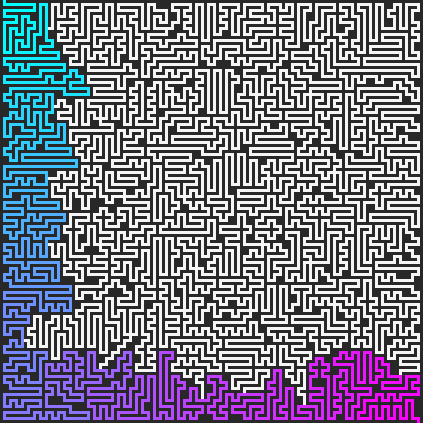

In [156]:
# _ = day23a(s1, visualize=True)
# _ = day23a_part2(s1, visualize=True)

_ = day23a(puzzle.input, visualize=True)

if SHOW_BIG_MEDIA:
  _ = day23a_part2(puzzle.input, visualize=True)  # ~15 s.

Cached result:<br/>
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day23b.png"/><br/>

day23c

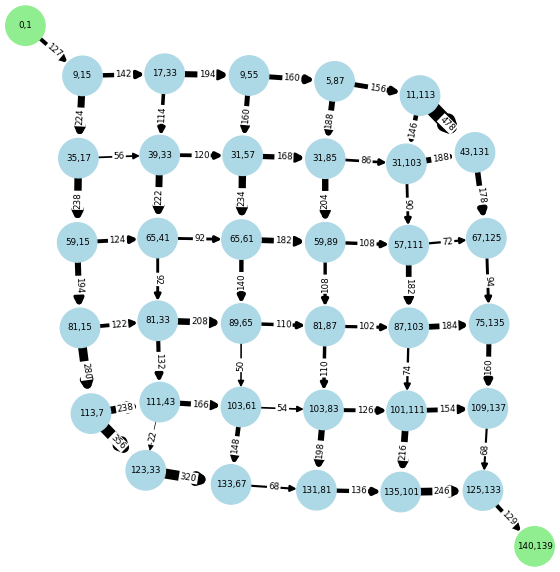

day23d

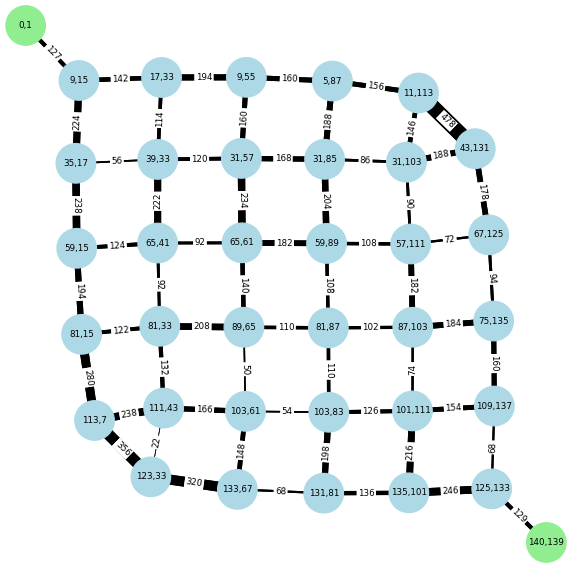

In [157]:
def day23_visualize_graph(s, *, part2=False, node_size=1000):
  grid = np.array([list(line) for line in s.splitlines()])

  graph_yx, start_yx, unused_target_yx = day23_graph_yx(s, part2)
  graph = networkx.DiGraph()
  for yx, paths in graph_yx.items():
    color = 'lightgreen' if yx[0] == 0 or yx[0] == grid.shape[0] - 1 else 'lightblue'
    graph.add_node(yx, node_color=color, label=f'{yx[0]},{yx[1]}')
    for yx2, path in paths.items():
      graph.add_edge(yx, yx2, weight=len(path))

  pos = hh.graph_layout(graph, prog='neato')
  pos = hh.rotate_layout_so_node_is_on_left(pos, start_yx, math.tau / 8)
  most_upper_right_yx = max(graph_yx, key=lambda yx: yx[1] - yx[0])
  if pos[most_upper_right_yx][0] < np.mean(list(pos.values()), 0)[0]:
    pos = {node: (-y, -x) for node, (x, y) in pos.items()}  # Reflect about NW-SE.

  fig, ax = plt.subplots(figsize=(7, 7), dpi=90)
  ax.axes.set_aspect('equal')
  ax.set_axis_off()

  node_color = [attr for _, attr in graph.nodes(data='node_color')]
  networkx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color)

  labels = networkx.get_node_attributes(graph, 'label')
  networkx.draw_networkx_labels(graph, pos, labels=labels, font_size=7)

  width = [graph[u][v]['weight'] * 0.025 for u, v in graph.edges()]
  arrow_style = '-' if part2 else None
  networkx.draw_networkx_edges(graph, pos, node_size=node_size, width=width, arrowstyle=arrow_style)

  edge_labels = networkx.get_edge_attributes(graph, 'weight')
  bbox = dict(facecolor='white', edgecolor='none', pad=1)
  networkx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=7, bbox=bbox)

  fig.tight_layout(pad=0)
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  title = 'day23d' if part2 else 'day23c'
  media.show_image(image, border=True, title=title)
  plt.close(fig)


if 'networkx' in globals():
  media.set_max_output_height(3000)
  day23_visualize_graph(puzzle.input)
  day23_visualize_graph(puzzle.input, part2=True)

# TODO: Show the solution paths on these graphs.

In [158]:
def day23b(s, *, part2=False):  # Recursive function over integer nodes.
  graph, start, target = day23_graph(s, part2)

  def length_longest(node_index, visited):
    if node_index == target:
      return 0
    visited = visited | {node_index}
    max_dist = -(10**9)
    for node_index2, path_dist in graph[node_index]:
      if node_index2 not in visited:
        max_dist = max(max_dist, path_dist + length_longest(node_index2, visited))
    return max_dist

  return length_longest(start, set())


check_eq(day23b(s1), 94)
puzzle.verify(1, day23b)

day23b_part2 = functools.partial(day23b, part2=True)
check_eq(day23b_part2(s1), 154)
# puzzle.verify(2, day23b_part2)  # ~12.5 s.

(Part 1: 0.042 s)


In [159]:
def day23c(s, *, part2=False):  # Stack-based; fastest non-numba version.
  graph, start, target = day23_graph(s, part2)
  stack = [(start, 0, {start})]
  max_length = 0

  while stack:
    node, length, visited = stack.pop()
    if node == target:
      max_length = max(max_length, length)
      continue
    for node2, dist in graph[node]:
      if node2 not in visited:
        stack.append((node2, length + dist, visited | {node2}))

  return max_length


check_eq(day23c(s1), 94)
puzzle.verify(1, day23c)

day23c_part2 = functools.partial(day23c, part2=True)
check_eq(day23c_part2(s1), 154)
# puzzle.verify(2, day23c_part2)  # ~11 s.

(Part 1: 0.045 s)


In [160]:
@numba.njit
def day23_length_of_longest_path(graph_array, start, target):
  stack = [(start, 0, {start})]
  max_length = 0

  while stack:
    node, length, visited = stack.pop()
    if node == target:
      max_length = max(max_length, length)
      continue
    for node2, dist in graph_array[node]:
      if node2 >= 0 and node2 not in visited:
        stack.append((node2, length + dist, visited | {node2}))

  return max_length


def day23(s, *, part2=False):
  graph, start, target = day23_graph(s, part2)
  graph_array = np.full((len(graph), 4, 2), -1)  # np.int16 is no faster.
  for index, index2_paths in enumerate(graph):
    if index2_paths:
      graph_array[index, : len(index2_paths)] = index2_paths
  return day23_length_of_longest_path(graph_array, start, target)


check_eq(day23(s1), 94)
puzzle.verify(1, day23)

day23_part2 = functools.partial(day23, part2=True)
check_eq(day23_part2(s1), 154)
puzzle.verify(2, day23_part2)  # ~5 s (~90 s without numba).

(Part 1: 0.041 s)
(Part 2: 4.799 s)


<a name="day24"></a>
## Day 24: Intersecting 3D trajectories

- Part 1: Considering only the X and Y axes, check all pairs of hailstones' future paths for intersections.  How many of these intersections occur within the test area $\left[2\cdot 10^{14}, 4\cdot 10^{14}\right]^2$ ?

- Part 2: Determine the exact position and velocity the rock needs to have at time 0 so that it perfectly collides with every hailstone. What do you get if you add up the X, Y, and Z coordinates of that initial position?

---



In [161]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2023/day/24), `puzzle.input` has 300 lines:

308205470708820, 82023714100543, 475164418926765 @ 42, 274, -194
242904857760501, 351203053017504, 247366253386570 @ 147, -69, 131
258124591360173, 252205185038992, 113896142591148 @ -84, -5, 409
119941036591859, 163082879649081, 4691494807438 @ 289, 148, 407
372927849501650, 285533947592103, 437461879304479 @ -12, 6, -100
423113319634193, 64361816827016, 246241892391694 @ -58, 263, 134
150622464208533, 149858599917240, 207584399489928 @ 262, 231, 147
391511332725299, 330534334676760, 358504004483827 @ 9, -29, 30
 ...
498656290147091, 538361240124304, 268582792623204 @ -184, -317, 97
307319823330214, 212837294167901, 362657600345765 @ -152, 116, -294
435192298389546, 289376532398167, 437069442124209 @ -48, 10, -62
278650786090824, 331596936120429, 370148896367017 @ 96, -54, -28


The stored answers are: `{1: '17867', 2: '557743507346379'}`

In [162]:
s1 = """\
19, 13, 30 @ -2,  1, -2
18, 19, 22 @ -1, -1, -2
20, 25, 34 @ -2, -2, -4
12, 31, 28 @ -1, -2, -1
20, 19, 15 @  1, -5, -3
"""

In [163]:
def day24a_part1(s, low=200_000_000_000_000, high=400_000_000_000_000):
  array = np.array([line.replace(' @', ',').split(',') for line in s.splitlines()], int)
  total = 0
  for row0, row1 in itertools.combinations(array, 2):
    pos0, vel0, pos1, vel1 = row0[:2], row0[3:5], row1[:2], row1[3:5]
    try:
      t = np.linalg.solve(np.array([vel0, -vel1]).T, pos1 - pos0)
    except np.linalg.LinAlgError:
      continue
    total += all(t > 0) and all(low <= c <= high for c in pos0 + t[0] * vel0)
  return total


check_eq(day24a_part1(s1, low=7, high=27), 2)
puzzle.verify(1, day24a_part1)

(Part 1: 0.447 s)


In [164]:
# The Python exception overhead is greatly reduced when using numba.
@numba.njit
def day24_compute(array, low, high):
  total = 0
  for i0, row0 in enumerate(array):
    for row1 in array[i0 + 1 :]:
      pos0, vel0, pos1, vel1 = row0[:2], row0[3:5], row1[:2], row1[3:5]
      try:
        matrix = np.column_stack((vel0, -vel1))
        t = np.linalg.solve(matrix, pos1 - pos0)
      except Exception:  # For numba. # pylint: disable=broad-exception-caught
        continue
      if np.all(t > 0):
        intersection = pos0 + t[0] * vel0
        total += int(np.all(low <= intersection) and np.all(intersection <= high))
  return total


def day24_part1(s, low=200_000_000_000_000, high=400_000_000_000_000):
  array = np.array([line.replace(' @', ',').split(',') for line in s.splitlines()], float)
  return day24_compute(array, low, high)


check_eq(day24_part1(s1, low=7, high=27), 2)
puzzle.verify(1, day24_part1)

(Part 1: 0.017 s)


In [165]:
def day24a_part2(s, debug=True):  # scipy.optimize.fsolve() fails.
  array = np.array([line.replace(' @', ',').split(',') for line in s.splitlines()], float)[:3]

  def fun(vars):
    pos, vel, t = vars[:3], vars[3:6], vars[6:]
    return [
        row[j] - pos[j] + t[i] * (row[j + 3] - vel[j])
        for i, row in enumerate(array)
        for j in range(3)
    ]

  if len(array) < 10:
    initial_guess = [2] * 3 + [1] * 3 + [1.0] * len(array)
  else:
    initial_guess = [1e6] * 3 + [1e6] * 3 + [1.0] * len(array)

  x = scipy.optimize.fsolve(fun, initial_guess, xtol=1e-12)
  if debug:
    print([float(c) for c in x[:6]])
  return sum(int(c + 0.5) for c in x[0:3])


if 0:
  check_eq(day24a_part2(s1), 47)
# [15.985268302417362, 21.273134077648493, 29.030617524035662, -0.979297154721275, -1.0234084222401216, -2.071566261229855]

if 0:
  puzzle.verify(2, day24a_part2)
# [-19802.468581623583, -5268.626978559192, -30530.809116247, -15607.423863406018, -22566.37952527879, -15894.101349380377]

In [166]:
def day24b_part2(s, expect=None, debug=False, use=10):  # scipy.optimize.minimize fails.
  array = np.array([line.replace(' @', ',').split(',') for line in s.splitlines()], float)[:use]

  def fun(vars):
    pos, vel, t = vars[:3], vars[3:6], vars[6:]
    return ((array[:, :3] - pos + t[:, None] * (array[:, 3:6] - vel)) ** 2).sum()

  if len(array) < 10:
    initial_guess = [2] * 3 + [1] * 3 + [1.0] * len(array)
  else:
    initial_guess = [1e6] * 3 + [1e6] * 3 + [1.0] * len(array)

  methods = 'Nelder-Mead Powell CG BFGS L-BFGS-B TNC COBYLA SLSQP'.split()
  # Omit because require gradient: Newton-CG dogleg trust-ncg trust-exact trust-krylov.
  # Omit because gives warning: trust-constr.
  for method in methods:
    solution = scipy.optimize.minimize(fun, initial_guess, method=method, tol=1e-12)
    x = solution.x
    answer = sum(int(c + 0.5) for c in x[0:3])
    correct = -1 if expect is None else int(answer == expect)
    print(f'# {method=:12}  success={int(solution.success)}  {correct=}')
    if debug:
      print([float(c) for c in x[:6]])


if 0:
  day24b_part2(s1, expect=47)
# method=Nelder-Mead   success=0  correct=0
# method=Powell        success=0  correct=1
# method=CG            success=0  correct=1
# method=BFGS          success=0  correct=1
# method=L-BFGS-B      success=1  correct=1
# method=TNC           success=0  correct=0
# method=COBYLA        success=0  correct=0
# method=SLSQP         success=1  correct=1

if 0:
  day24b_part2(puzzle.input, expect=557743507346379)
# method=Nelder-Mead   success=0  correct=0
# method=Powell        success=0  correct=0
# method=CG            success=1  correct=0
# method=BFGS          success=1  correct=0
# method=L-BFGS-B      success=1  correct=0
# method=TNC           success=1  correct=0
# method=COBYLA        success=0  correct=0
# method=SLSQP         success=1  correct=0

In [167]:
def day24c_part2(s, debug=False, use=10):  # scipy.optimize.minimize fails.
  array = np.array([line.replace(' @', ',').split(',') for line in s.splitlines()], float)[:use]

  def fun(vars):
    pos, vel, t = vars[:3], vars[3:6], vars[6:]
    return ((array[:, :3] - pos + t[:, None] * (array[:, 3:6] - vel)) ** 2).sum()

  if len(array) < 10:
    initial_guess = [2] * 3 + [1] * 3 + [1.0] * len(array)
  else:
    initial_guess = [1e6] * 3 + [1e6] * 3 + [1.0] * len(array)

  x = scipy.optimize.minimize(fun, initial_guess).x
  if debug:
    print([float(c) for c in x[:6]])
  return sum(int(c + 0.5) for c in x[0:3])


check_eq(day24c_part2(s1), 47)
# puzzle.verify(2, day24c_part2)

In [168]:
# TODO: Try defining the gradient to see if this robustifies or accelerates the search.

In [169]:
def day24d_part2(s, debug=False, use=20):  # scipy.optimize.least_squares() succeeds.
  # use=10 was OK for one puzzle.input, but use=20 was required for another one.
  array = np.array([line.replace(' @', ',').split(',') for line in s.splitlines()], float)[:use]

  def fun(vars):
    pos, vel, t = vars[:3], vars[3:6], vars[6:]
    return (array[:, :3] - pos + t[:, None] * (array[:, 3:6] - vel)).reshape(-1)

  if len(array) < 10:  # Somehow the choice of initial guess is important.
    initial_guess = [2] * 3 + [1] * 3 + [1.0] * len(array)
  else:
    initial_guess = [1e6] * 3 + [1e6] * 3 + [1.0] * len(array)

  # Unlike with scipy.optimize.fsolve, here we can have a non-square system.
  x = scipy.optimize.least_squares(fun, initial_guess, xtol=1e-12).x
  if debug:
    print([float(c) for c in x[:6]])
  return sum(int(c + 0.5) for c in x[0:3])


check_eq(day24d_part2(s1), 47)
# [24.0, 13.0, 10.000000000000002, -3.0000000000000004, 1.0000000000000002, 1.9999999999999998]

puzzle.verify(2, day24d_part2)
# 159153037374407.0, 228139153674672.0, 170451316297300.0, 245.00000000000003, 75.00000000000001, 221.0]

(Part 2: 0.171 s)


In [170]:
def day24e_part2(s, debug=False):
  array = np.array([line.replace('@', ',').split(',') for line in s.splitlines()], int)
  px, py, pz, vx, vy, vz, t0, t1, t2 = sympy.symbols('px py pz vx vy vz t0 t1 t2')
  equations = [
      (array[0, 0] + t0 * array[0, 3]) - (px + vx * t0),
      (array[0, 1] + t0 * array[0, 4]) - (py + vy * t0),
      (array[0, 2] + t0 * array[0, 5]) - (pz + vz * t0),
      (array[1, 0] + t1 * array[1, 3]) - (px + vx * t1),
      (array[1, 1] + t1 * array[1, 4]) - (py + vy * t1),
      (array[1, 2] + t1 * array[1, 5]) - (pz + vz * t1),
      (array[2, 0] + t2 * array[2, 3]) - (px + vx * t2),
      (array[2, 1] + t2 * array[2, 4]) - (py + vy * t2),
      (array[2, 2] + t2 * array[2, 5]) - (pz + vz * t2),
  ]
  (solution,) = sympy.solve(equations, (px, py, pz, vx, vy, vz, t0, t1, t2))
  if debug:
    print(solution)
  return sum(solution[:3])


check_eq(day24e_part2(s1), 47)
# (24, 13, 10, -3, 1, 2, 5, 3, 4)

puzzle.verify(2, day24e_part2)
# (159153037374407, 228139153674672, 170451316297300, 245, 75, 221, 734248440071, 854610412103, 300825392054)
# (363206674204110, 368909610239045, 156592420220258, -164, -127, 223, 807026090068, 665395648062, 117549288974)

(Part 2: 0.037 s)


In [171]:
def day24f_part2(s, use=3):  # More concise.
  array = np.array([line.replace('@', ',').split(',') for line in s.splitlines()], int)
  p, v, t = sympy.symbols('p(:3)'), sympy.symbols('v(:3)'), sympy.symbols(f't(:{use})')
  equations = [
      array[i, j] - p[j] + t[i] * (array[i, 3 + j] - v[j]) for i in range(3) for j in range(3)
  ]
  return sum(sympy.solve(equations, (*p, *v, *t))[0][:3])


check_eq(day24f_part2(s1), 47)
puzzle.verify(2, day24f_part2)

(Part 2: 0.033 s)


In [172]:
def day24_part2(s):  # Most concise.
  rows = [list(map(int, re.findall(r'[-\d]+', line))) for line in s.splitlines()]
  p, v, ts = (sympy.symbols(f'{ch}(:3)') for ch in 'pvt')
  equations = [
      row[j] - p[j] + t * (row[3 + j] - v[j]) for row, t in zip(rows, ts) for j in range(3)
  ]
  return sum(sympy.solve(equations, (*p, *v, *ts))[0][:3])


check_eq(day24_part2(s1), 47)
puzzle.verify(2, day24_part2)

(Part 2: 0.023 s)


<a name="day25"></a>
## Day 25: Graph cut

- Part 1: Find the three wires you need to disconnect in order to divide the components into two separate groups. What do you get if you multiply the sizes of these two groups together?

- Part 2: No second part on day 25.

---



In [173]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2023/day/25), `puzzle.input` has 1_266 lines:

rjq: mkj bbr xrh mnn
zch: zvf pnk bbk njb
jms: vhm gdp jxq tmj
qkz: qpl rlb rfv
lnl: knh nls
hlb: tfj qpl mvk bkq
tnh: gvl
fdq: xrc shj
 ...
cjq: zpv mxc srv zqj
vpf: fxr dpq
gcf: fmj xdt
gxt: tph nvb bnh


The stored answers are: `{1: '601344', 2: ''}`

In [174]:
# spellcheck=off
s1 = """\
jqt: rhn xhk nvd
rsh: frs pzl lsr
xhk: hfx
cmg: qnr nvd lhk bvb
rhn: xhk bvb hfx
bvb: xhk hfx
pzl: lsr hfx nvd
qnr: nvd
ntq: jqt hfx bvb xhk
nvd: lhk
lsr: lhk
rzs: qnr cmg lsr rsh
frs: qnr lhk lsr
"""
# spellcheck=on

In [175]:
def day25_graph(s):
  graph = networkx.Graph()
  for line in s.splitlines():
    node, other_nodes = line.split(':')
    for node2 in other_nodes.split():
      graph.add_edge(node, node2)
  return graph

In [176]:
def day25_visualize(s):
  graph = day25_graph(s)
  pos = hh.graph_layout(graph, prog='neato')
  pos = hh.rotate_layout_so_principal_component_is_on_x_axis(pos)

  fig, ax = plt.subplots(figsize=(20, 20), dpi=80)
  ax.axes.set_aspect('equal')
  networkx.draw(graph, pos, node_color='#40A0E0', with_labels=True, font_size=8)

  fig.tight_layout(pad=0)
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  media.show_image(image, border=True, title='day25')
  plt.close(fig)


if SHOW_BIG_MEDIA:
  day25_visualize(puzzle.input)

Cached result:<br/>
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2023/results/day25.png"/>

In [177]:
def day25_timing_experiments(s):
  graph = day25_graph(s)

  with hh.timing('neato layout'):
    hh.graph_layout(graph, prog='neato')  # ~4.4 s.

  with hh.timing('dot layout'):
    hh.graph_layout(graph, prog='dot')  # ~3.1 s.

  with hh.timing('diameter'):
    networkx.diameter(graph)  # ~0.8 s (Value 13; it likely uses eccentricity().)

  with hh.timing('eccentricity'):  # ~0.8 s.
    networkx.eccentricity(graph)

  with hh.timing('shortest_path_length'):  # ~5 ms.
    source_node = next(iter(graph))
    networkx.single_source_shortest_path_length(graph, source_node)


if 0:
  day25_timing_experiments(puzzle.input)

In [178]:
def day25a(s):  # networkx.stoer_wagner
  graph = day25_graph(s)

  cut_value, partition = networkx.stoer_wagner(graph)
  assert cut_value == 3  # Three unweighted edges.
  component1, component2 = partition
  return len(component1) * len(component2)


check_eq(day25a(s1), 54)
# puzzle.verify(1, day25a)  # ~3.6 s.

In [179]:
def day25b(s):  # networkx.minimum_edge_cut
  graph = day25_graph(s)

  # (Adding "flow_func=networkx.algorithms.flow.shortest_augmenting_path" almost doubles the cost.)
  cutset = networkx.minimum_edge_cut(graph)
  assert len(cutset) == 3
  for node1, node2 in cutset:
    graph.remove_edge(node1, node2)
  component1, component2 = networkx.connected_components(graph)
  return len(component1) * len(component2)


check_eq(day25b(s1), 54)
puzzle.verify(1, day25b)  # ~2.7 s

(Part 1: 2.672 s)


In [180]:
def day25(s, num_random_edges=100):
  graph = day25_graph(s)
  # The graph in the puzzle input has a dumbbell connectivity structure.
  # Therefore, a heuristic algorithm is to examine the shortest paths between
  # many random pairs of nodes and determine the most common path edges.
  rng = np.random.default_rng(0)
  edge_counts = collections.Counter[tuple[str, str]]()
  nodes = np.array(list(graph.nodes()))

  for _ in range(num_random_edges):
    node_pair = rng.choice(nodes, size=2, replace=False)
    path = networkx.shortest_path(graph, source=node_pair[0], target=node_pair[1])
    for edge in itertools.pairwise(path):
      edge_counts[tuple(sorted(edge))] += 1

  for (node1, node2), _ in edge_counts.most_common(3):
    graph.remove_edge(node1, node2)
  component1, component2 = networkx.connected_components(graph)
  return len(component1) * len(component2)


# check_eq(day25(s1), 54)  # It fails on this "non-dumbbell" graph.
puzzle.verify(1, day25)

(Part 1: 0.021 s)


In [181]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)

(Part 2: 0.000 s)


<a name="timings"></a>
## Timings

In [182]:
advent.show_times()

day_1    part_1: 0.002   part_2: 0.002
day_2    part_1: 0.000   part_2: 0.001
day_3    part_1: 0.012   part_2: 0.006
day_4    part_1: 0.001   part_2: 0.001
day_5    part_1: 0.001   part_2: 0.001
day_6    part_1: 0.000   part_2: 0.000
day_7    part_1: 0.003   part_2: 0.003
day_8    part_1: 0.002   part_2: 0.009
day_9    part_1: 0.004   part_2: 0.005
day_10   part_1: 0.008   part_2: 0.010
day_11   part_1: 0.003   part_2: 0.002
day_12   part_1: 0.003   part_2: 0.009
day_13   part_1: 0.011   part_2: 0.011
day_14   part_1: 0.002   part_2: 0.016
day_15   part_1: 0.001   part_2: 0.005
day_16   part_1: 0.001   part_2: 0.014
day_17   part_1: 0.071   part_2: 0.185
day_18   part_1: 0.001   part_2: 0.001
day_19   part_1: 0.005   part_2: 0.003
day_20   part_1: 0.019   part_2: 0.063
day_21   part_1: 0.003   part_2: 0.042
day_22   part_1: 0.009   part_2: 0.045
day_23   part_1: 0.041   part_2: 4.799
day_24   part_1: 0.017   part_2: 0.023
day_25   part_1: 0.021   part_2: 0.000
Total time:  5.497 s


In [183]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [184]:
if 1:  # Look for unwanted pollution of namespace.
  for _name in globals().copy():
    if not (re.match(r'^_|(day|Day|s)\d+|(puzzle$)', _name) or _name in _ORIGINAL_GLOBALS):
      print(_name)

In [185]:
if 0:  # Lint.
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pyink; pyink --diff .')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo pylint; pylint -j8 . || true')
  hh.run(
      'echo flake8; flake8 --indent-size=2 --exclude .ipynb_checkpoints'
      ' --extend-ignore E129,E203,E302,E305,E501,E741'
  )

In [186]:
hh.show_notebook_cell_top_times()

# Total time: 57.29 s
# In[142] def day21_visualize(s, num_rings=2, no_flicker=True):\n      6.141 s
# In[160] @numba.njit\ndef day23_length_of_longest_path(graph_array,   6.078 s
# In[ 55] def day8_visualize(s):\n  routes = {line[:3]: (line[7:10],   3.517 s
# In[ 98] def day14_part2_visualize(s, num=1_000_000_000):\n  grid =   3.444 s
# In[179] def day25b(s):  # networkx.minimum_edge_cut\n  graph = day2  2.810 s
# In[164] # The Python exception overhead is greatly reduced when      2.692 s
# In[115] def day17a(s, *, part2=False, visualize=False, rep=2):  #    2.593 s
# In[116] _ = day17a(puzzle.input, visualize=True)\n_ = day17a(        2.587 s
# In[109] def day16a(s, *, part2=False):  # Initial slow version: (    2.008 s
# In[117] @numba.njit  # First numba implementation.\ndef day17b_      1.988 s
# In[118] @numba.njit  # Faster numba, using flat array, padding,      1.590 s
# In[ 88] # Dynamic programming with precomputed valid word            1.266 s
# In[120] def day17(s, *, part

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->